In [1]:
import numpy as np
import lightkurve as lk
import pandas as pd
import batman
import matplotlib.pyplot as plt

# First, we will generate a simulated light curve

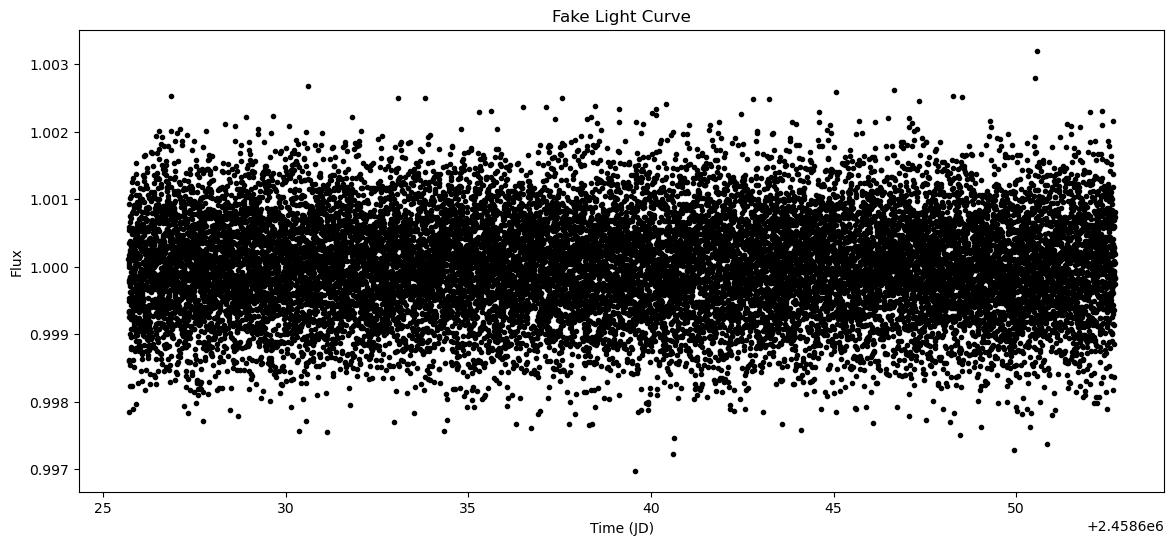

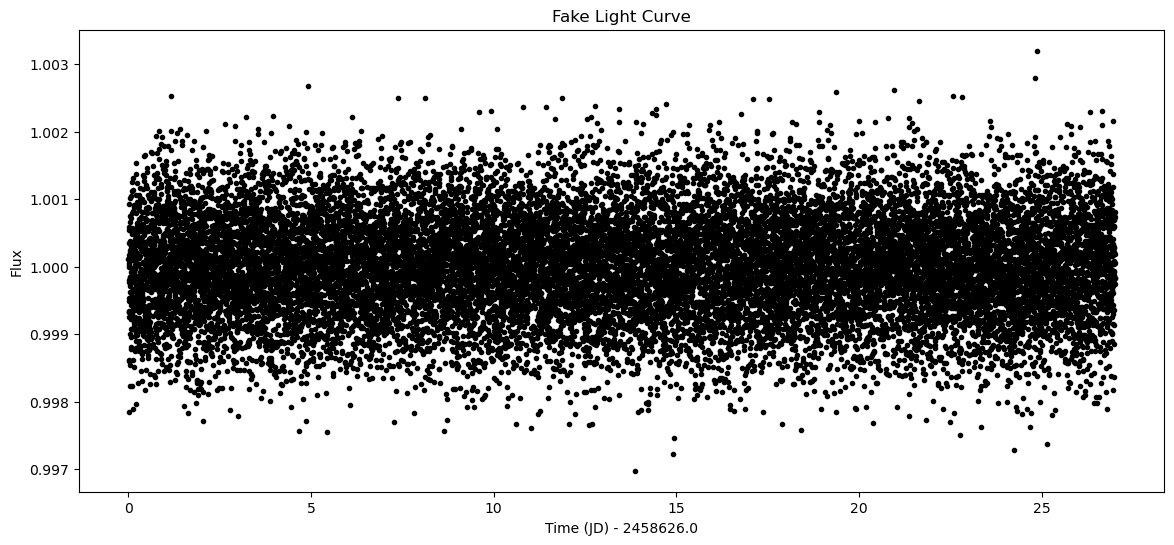

In [2]:
fs=10 # fontsize for text in figures
#ndays = 10 #days - the smaller number is for debugger for the TLS to run quicker


ndays = 27 #days
cadence_minutes = 2 # take measurement every 30 minutes
pts_per_day = (1 * 24 * 60) / cadence_minutes # data points per day
scatter_frac = 0.00075  # add scatter to data to make it realistic

start = 0.0
stop = ndays
stepsize = int(ndays * pts_per_day)


t = 2458625.7 + np.linspace(start, stop, stepsize) 

flux = 1.0 + np.random.randn(t.size) * scatter_frac
fluxerr = np.ones_like(flux) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.plot(t,flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Fake Light Curve")
# plt.ylim(0.9975,1.0025)
plt.show()

plt.figure(figsize=(14,6)) #width, height
plt.plot(t-np.min(t),flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD) - "+str(np.round(np.min(t))))
plt.ylabel("Flux")
plt.title("Fake Light Curve")
# plt.ylim(0.9975,1.0025)
plt.show()

# second, we will simulate transit events and inject them into our simulated light curve

In [3]:
# useful function for calculating semi-major axis
def SMA_AU_from_Period_to_stellar(Period,R_star,M_star):
    """   
    This function will calculate the Semi-Major Axis (SMA)
    using Kepler's third law.
    
    Input Parameters
    ----------
    Period : float
        Orbital period in days
    R_star : float
        Stellar Radius in solar radii
    M_star : float
        Stellar Mass in solar masses
    Returns
    -------
        * SMA
            Semi-Major Axis in stellar units
        * SMA_cm
            Semi-Major Axis in units of centimeters        
    """    
    #assumes circular orbit
    #using Kepler's third law, calculate SMA
    #solar units
    import astropy.units as u
    from astropy import constants as const 
    RS = u.R_sun.to(u.cm) # in cm
    MS = u.M_sun.to(u.g) # in grams
    #
    G = const.G.cgs.value #cm^3 per g per s^2
    #
    R = R_star*RS
    M = M_star*MS
    P=Period*60.0*24.0*60.0 #in seconds
    #
    #SMA  
    SMA_cm = ((G*M*(P**2))/(4*(np.pi**2)))**(1/3)
    #
    #note R_star is already in solar units so we need to convert to cm using
    # solar radius as a constant
    Stellar_Radius = R #now in cm
    #
    SMA = SMA_cm / Stellar_Radius #now unitless (cm / cm)
    return SMA, SMA_cm

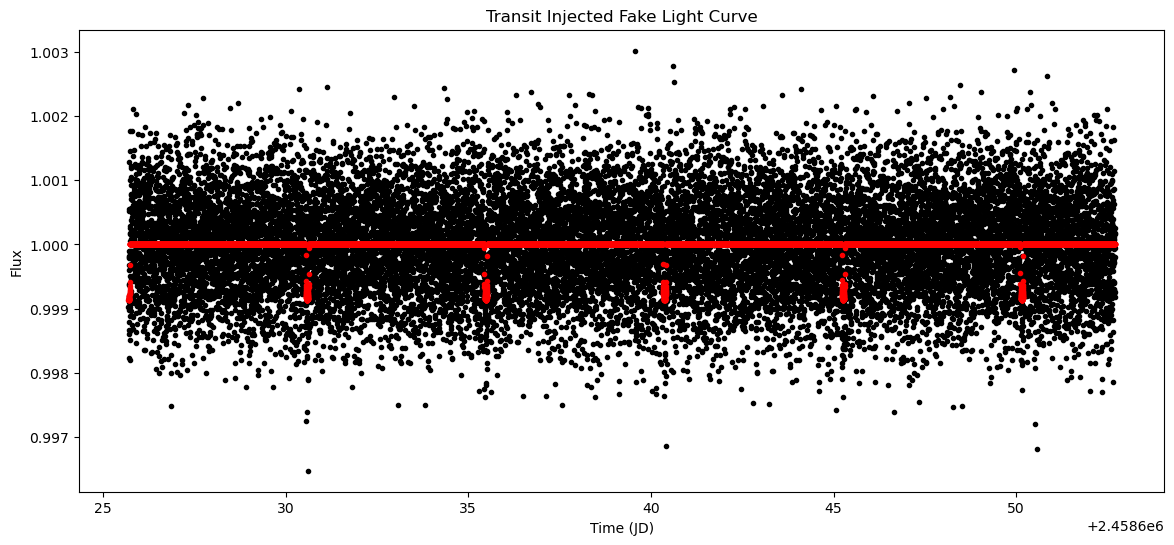

In [4]:
# defining astro constants
import astropy.units as u
R_earth = u.R_earth.to('cm')
R_sun = u.R_sun.to('cm')
M_sun = u.M_sun.to('g')
R_star = 0.5 #stellar radius in units of solar radii
M_star = 0.5 #stellar mass in units of solar mass

# defining simulated transit parameters of orbiting planet
P = 4.8910 #oribital period in days
RP =  (1.5 * R_earth / (R_star * R_sun) ) #planet radius in units of stellar radius

#below is semi-major axis (see function above)
SMA,SMA_cm = SMA_AU_from_Period_to_stellar(P,R_star,M_star) 

time_start = t[0] #[0] =first data point in array

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = P  # orbital period
ma.rp = RP  # planet radius (in units of stellar radii) 
ma.a = SMA  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
ma.u = [0.25, 0.25]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, t)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

#inject simulated transits into fake data
injectedflux = synthetic_signal- flux+1

plt.figure(figsize=(14,6)) #width, height
plt.plot(t,injectedflux,marker='.',color='black',linestyle='none')
plt.plot(t,synthetic_signal,marker='.',color='red',linestyle='none')

plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
# plt.ylim(0.9975,1.0025)
plt.show()

# we can convert our transit-injected fake light curve into a LightKurve object

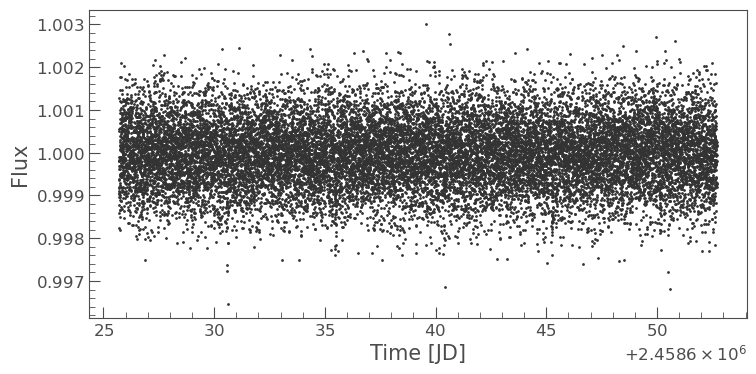

In [5]:
sim_LC = lk.LightCurve(time=t,flux=injectedflux,flux_err=fluxerr)

#plot scatter plot with new LightCurve object
sim_LC.scatter()
plt.show()

# we can make phase-folded plot with our chosen transit injection parameters

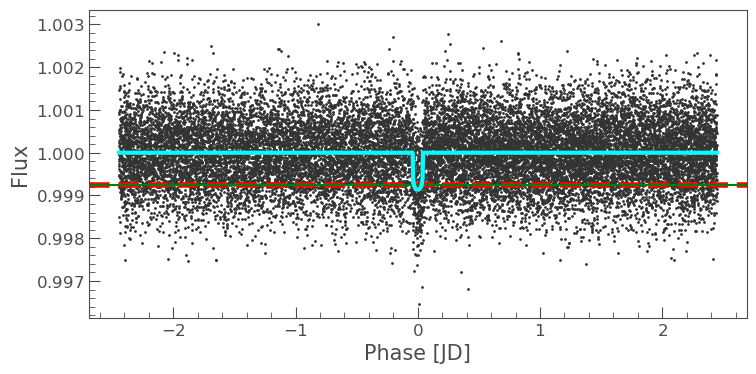

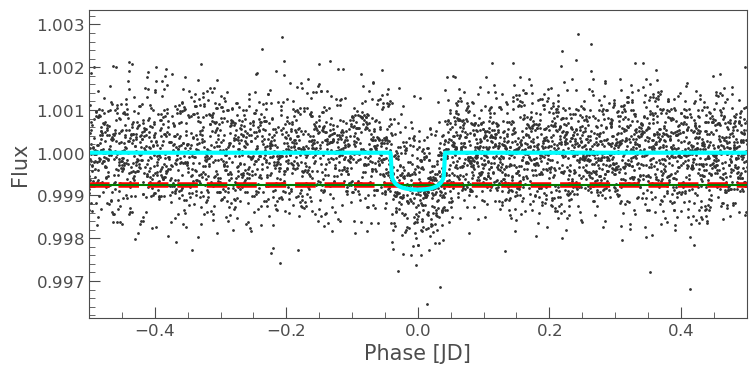

In [6]:
def predicted_transit_depth(injected_planet_radius, R_star,planet_units):
    import astropy.units as u
    if planet_units=='stellar':
        # convert from RP in stellair radii to RP in earth radii
        RP_earth = injected_planet_radius * (R_star * u.R_sun.to(u.cm)) / (u.R_earth.to(u.cm))
    if planet_units=='earth':
        RP_earth = injected_planet_radius 
    #print(injected_planet_radius_in_stellar_units,RP_earth)
    depth = ( (RP_earth * u.R_earth.to(u.cm)) / ( R_star*u.R_sun.to(u.cm) ) )**2
    return depth


ax=sim_LC.fold(period=P,epoch_time=time_start).scatter()

#showing how to use both inputs of "planet_units"

ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(1.5 * R_earth / (R_star * R_sun) ),
                                       R_star=R_star,planet_units='stellar'),color='red',lw=4,linestyle='--')

ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(1.5),
                                       R_star=R_star,planet_units='earth'),color='green')

inj_model_LC = lk.LightCurve(time=sim_LC.time,flux=synthetic_signal,flux_err=sim_LC.flux_err)
inj_model_LC.fold(period=P,epoch_time=time_start).plot(ax=ax,color='cyan',lw=3)
plt.show()



ax=sim_LC.fold(period=P,epoch_time=time_start).scatter()

#showing how to use both inputs of "planet_units"
ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(1.5 * R_earth / (R_star * R_sun) ),
                                       R_star=R_star,planet_units='stellar'),color='red',lw=4,linestyle='--')

ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(1.5),
                                       R_star=R_star,planet_units='earth'),color='green')

inj_model_LC.fold(period=P,epoch_time=time_start).plot(ax=ax,color='cyan',lw=3)
ax.set_xlim(-0.5,0.5)
plt.show()

# How is phase calculated?

## Pages 1-8 of this document helps illustrate:
## [ https://www.aavso.org/sites/default/files/Chapter12.pdf ]

# In steps:
## 1) Identify a "reference time", a time to mark the beginning of periodic actvity or other event worth referencing.
## 2) with a period of the periodic event, we can calculate the number of times this event occurred before/after our reference time
## 3) stack periodic events on top of each other
## 4) to have the stacked periodic events line up and be centered in our diagram, we have to shift the orbital phases by a half-period


# Step 1: Identify a "reference time", a time to mark the beginning of periodic actvity or other event worth referencing.

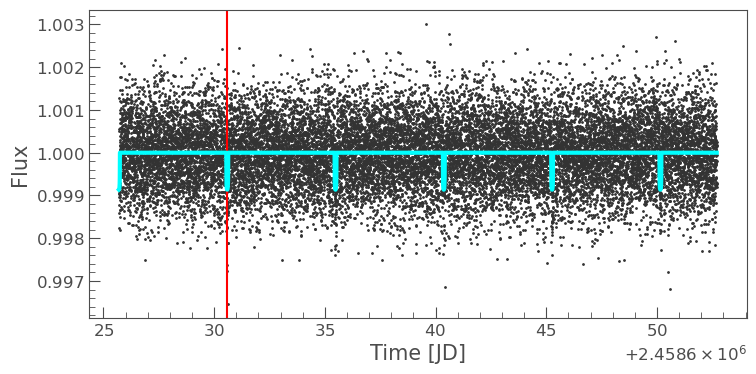

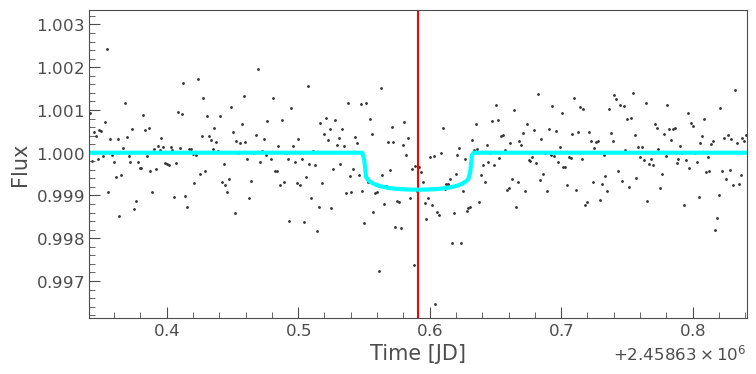

In [7]:
sim_LC = lk.LightCurve(time=t,flux=injectedflux,flux_err=fluxerr)
ax=sim_LC.scatter()
ax.axvline(x= time_start + P,color='red')
inj_model_LC.plot(ax=ax,color='cyan',lw=3)
plt.show()



ax=sim_LC.scatter()
ax.axvline(x= time_start + P,color='red')
inj_model_LC.plot(ax=ax,color='cyan',lw=3)
ax.set_xlim(time_start + P - 6/24 , time_start + P + 6/24) #+/- 6 hours of first "full" transit event
plt.show()

# Step 2: with a period of the periodic event, we can calculate the number of times this event occurred before/after our reference time

[-4.891      -4.88961104 -4.88822208 ... 22.10622208 22.10761104
 22.109     ]
 
[-1.         -0.99971602 -0.99943203 ...  4.51977552  4.52005951
  4.52034349]


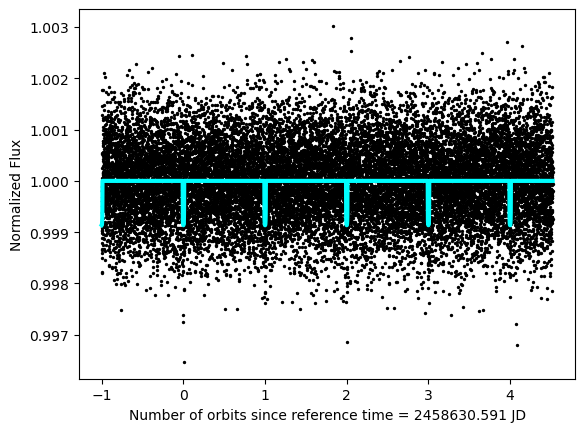

In [8]:
# practice calculating phase
ref_time = ma.t0 + ma.per

newt = sim_LC.time.value - (ref_time)
newt_model = inj_model_LC.time.value - (ref_time)
print(newt)
print(' ')

number_of_orbits = newt / ma.per
print(number_of_orbits)

plt.scatter(number_of_orbits, sim_LC.flux.value, s=2,color='black')
plt.plot(number_of_orbits, inj_model_LC.flux.value, lw=3,color='cyan')
plt.ylabel('Normalized Flux')
plt.xlabel('Number of orbits since reference time = '+str(np.round(ref_time,3))+' JD')
plt.show()

# Step 3: stack periodic events on top of each other

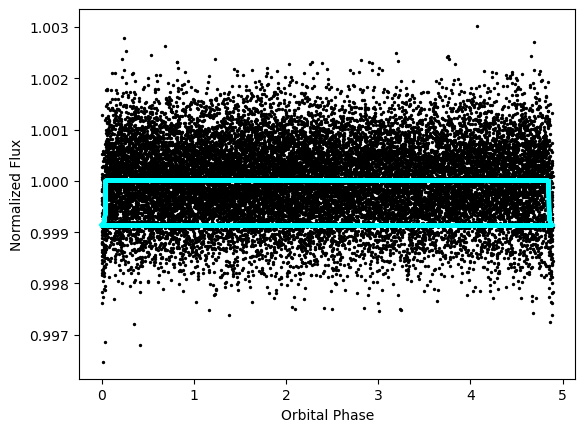

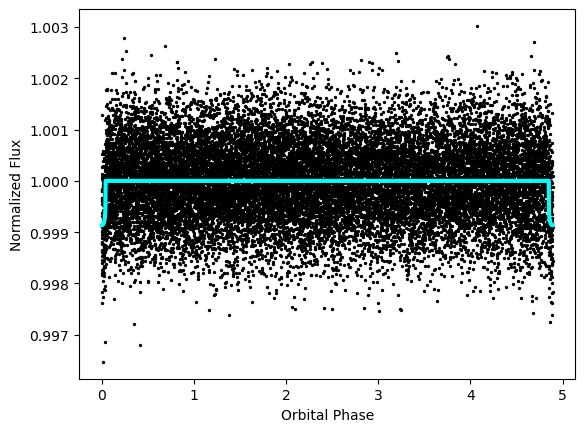

In [9]:
# note how now negative "orbits" no longer occur, they now start at 0 (periods from our reference time)

def phasefold(t,T0,P):
#     phase=(t - T0 ) % P
    phase=np.mod(t-T0,P)
    return phase

phase = phasefold(sim_LC.time.value, ref_time , ma.per)
model_phase = phasefold(inj_model_LC.time.value, ref_time , ma.per)
plt.scatter(phase, sim_LC.flux.value, s=2,color='black')
plt.plot(model_phase, inj_model_LC.flux.value, lw=3,color='cyan')
plt.ylabel('Normalized Flux')
plt.xlabel('Orbital Phase')
plt.show()

# note how these lines connect strangely? This is because we also have to sort our phases from low to high
def phasefold(t,f,T0,P):
#     phase=(t - T0 ) % P
    phase=np.mod(t-T0,P)
    ind=np.argsort(phase, axis=0)
    sorted_phase = phase[ind]
    sorted_flux = f[ind]
    return sorted_phase,sorted_flux

phase,fold_flux = phasefold(sim_LC.time.value, sim_LC.flux.value, ref_time , ma.per)
model_phase,model_fold_flux = phasefold(inj_model_LC.time.value,inj_model_LC.flux.value, ref_time , ma.per)
plt.scatter(phase, fold_flux, s=2,color='black')
plt.plot(model_phase, model_fold_flux, lw=3,color='cyan')
plt.ylabel('Normalized Flux')
plt.xlabel('Orbital Phase')
plt.show()


# Step 4: to have the stacked periodic events line up and be centered in our diagram, we have to shift the orbital phases by a half-period

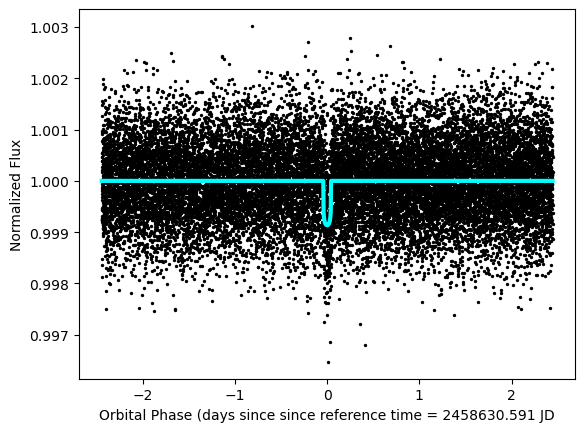

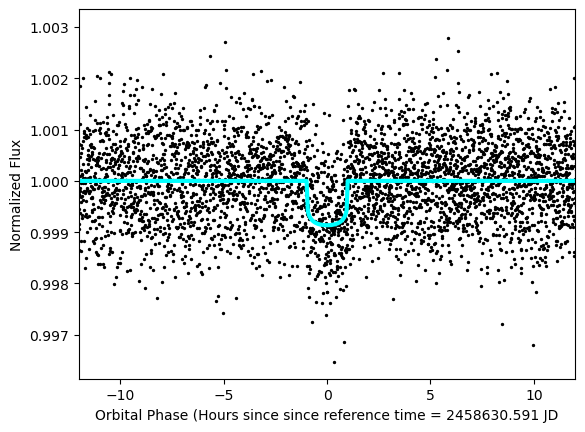

In [10]:
def phasefold_proper(t,f,T0,P):
    phase=(t - T0 + 0.5*P) % P - 0.5*P
    phase=(t - T0 + 0.5*P) % P - 0.5*P
    ind=np.argsort(phase, axis=0)
    return phase[ind],f[ind]

phase2,fold_flux2 = phasefold_proper(sim_LC.time.value,sim_LC.flux.value, 
                                     ref_time , ma.per)
model_phase2,model_fold_flux2 = phasefold_proper(inj_model_LC.time.value,inj_model_LC.flux.value,
                                                 ref_time , ma.per)

plt.scatter(phase2, fold_flux2, s=2,color='black')
plt.plot(model_phase2, model_fold_flux2, lw=3,color='cyan')
plt.ylabel('Normalized Flux')
plt.xlabel('Orbital Phase (days since since reference time = '+str(np.round(ref_time,3))+' JD')
# plt.xlim(-12/24,12/24)
plt.show()

plt.scatter(phase2*24, fold_flux2, s=2,color='black')
plt.plot(model_phase2*24, model_fold_flux2, lw=3,color='cyan')
plt.ylabel('Normalized Flux')
plt.xlabel('Orbital Phase (Hours since since reference time = '+str(np.round(ref_time,3))+' JD')
plt.xlim(-12,12)
plt.show()


# Note: the first diagram is identical to lightkurve's ".fold" scatter plot
#  BUT
# you can't modify whether you want the x-axis to be in units of days or hours

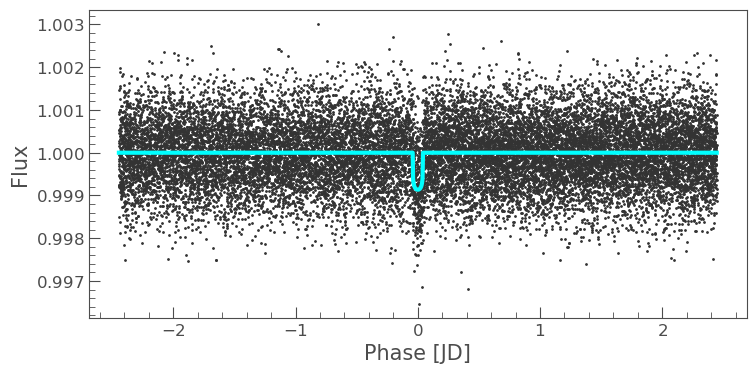

In [11]:
ax=sim_LC.fold(period=ma.per,epoch_time=ref_time).scatter()
inj_model_LC.fold(period=ma.per,epoch_time=ref_time).plot(ax=ax,color='cyan',lw=3)
plt.show()

# Now that we have a way to phasefold, let's try injecting a couple of types of transits

In [12]:
def transit_injection(fake_time,fake_flux,fake_flux_err,
                     inject_P,inject_RP, inject_T0, RS, MS):  # T0 - reference time / mid-transit time
    
    # defining astro constants
    import astropy.units as u
    R_earth = u.R_earth.to('cm')
    R_sun = u.R_sun.to('cm')
    M_sun = u.M_sun.to('g')
    R_star = RS #stellar radius in units of solar radii
    M_star = MS #stellar mass in units of solar mass

    # defining simulated transit parameters of orbiting planet
    P = inject_P #oribital period in days
    RP =  (inject_RP * R_earth / (R_star * R_sun) ) #planet radius in units of stellar radius

    #below is semi-major axis (see function above)
    SMA,SMA_cm = SMA_AU_from_Period_to_stellar(P,R_star,M_star) 

    time_start = inject_T0 #[0] =first data point in array

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = P  # orbital period
    ma.rp = RP  # planet radius (in units of stellar radii) 
    ma.a = SMA  # semi-major axis (in units of stellar radii)
    ma.inc = 90  # orbital inclination (in degrees)
    ma.ecc = 0  # eccentricity
    ma.w = 90  # longitude of periastron (in degrees)
    ma.u = [0.25, 0.25]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, fake_time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    #inject simulated transits into fake data
    injectedflux = synthetic_signal- fake_flux + 1

    plt.figure(figsize=(14,6)) #width, height
    plt.plot(fake_time,injectedflux,marker='.',color='black',linestyle='none')
    plt.plot(fake_time,synthetic_signal,marker='.',color='red',linestyle='none')

    plt.axhline(y=1-predicted_transit_depth(injected_planet_radius=(ma.rp),
                                       R_star=R_star,planet_units='stellar'),color='cyan',linestyle='--')

    plt.xlabel("Time (JD)")
    plt.ylabel("Flux")
    plt.title("Transit Injected Fake Light Curve")
    plt.show()
    
    injected_LC = lk.LightCurve(time=fake_time,
                                flux=injectedflux,
                                flux_err=fake_flux_err)
    
    inj_model_LC = lk.LightCurve(time=sim_LC.time,
                                 flux=synthetic_signal,
                                 flux_err=sim_LC.flux_err)
    
    qld = [0.25,0.25]
    
    fig=plt.figure(figsize=(14,6))
    ax=fig.add_subplot(111)
    injected_LC.fold(period=ma.per,epoch_time=ma.t0+ma.per).scatter(ax=ax,color='black')
    inj_model_LC.fold(period=ma.per,epoch_time=ma.t0+ma.per).plot(ax=ax,color='red',lw=3)
    ax.set_xlim(-12/24,12/24) #+/- 12 hours of injected transit
        
    ax.axhline(y=1-predicted_transit_depth(injected_planet_radius=(ma.rp),
                                       R_star=R_star,planet_units='stellar'),color='cyan',linestyle='--')
    
    plt.show()
    
    
    return injected_LC,inj_model_LC, qld

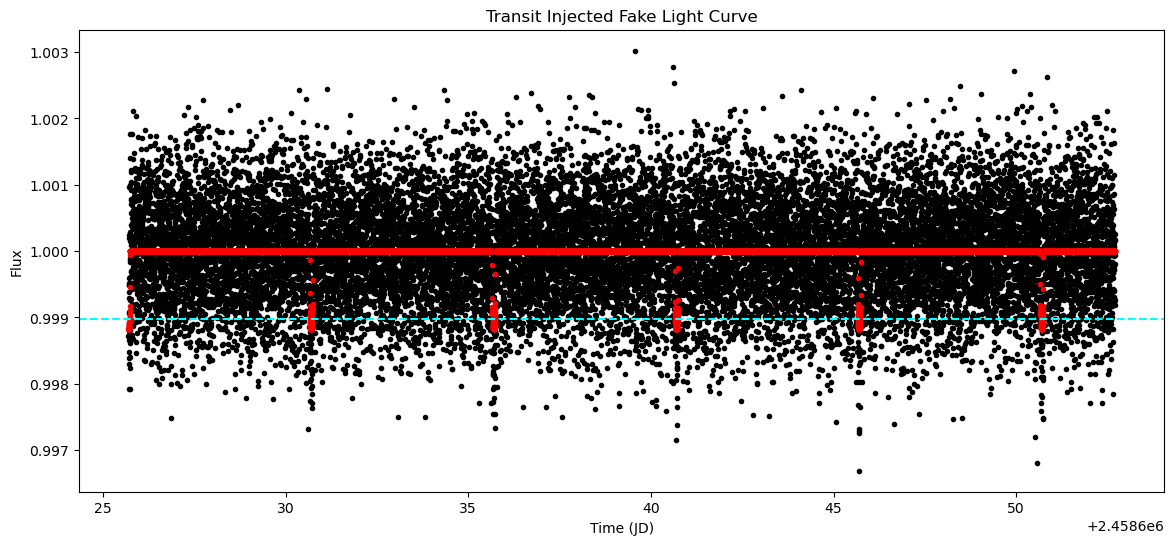

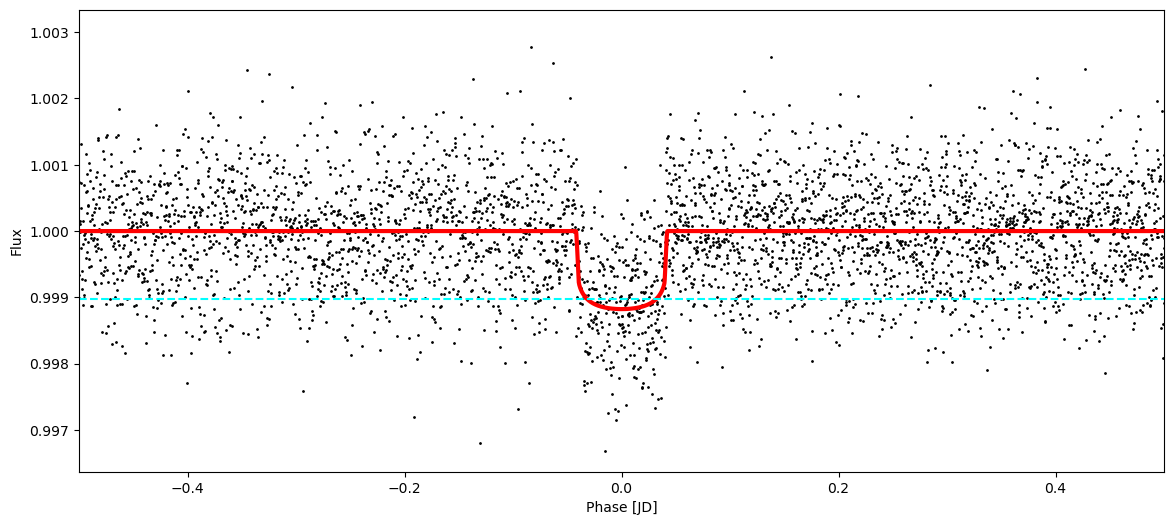

In [13]:
inj_RP1=1.75
inj_P1 = 5 


injected_LC1,injected_model_LC1,qld1 = transit_injection(fake_time=t,fake_flux=flux,fake_flux_err=fluxerr,
                                 inject_P=inj_P1,inject_RP=inj_RP1, inject_T0=t[0], 
                                 RS=R_star, MS=M_star )

# injected light curve are the red lines
# the light curve are the black dots

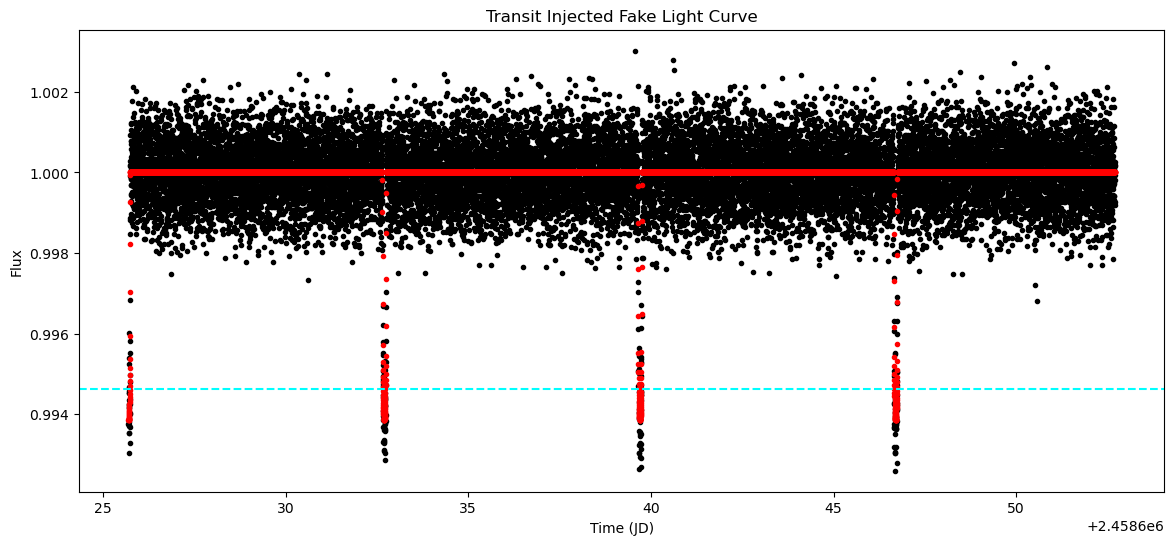

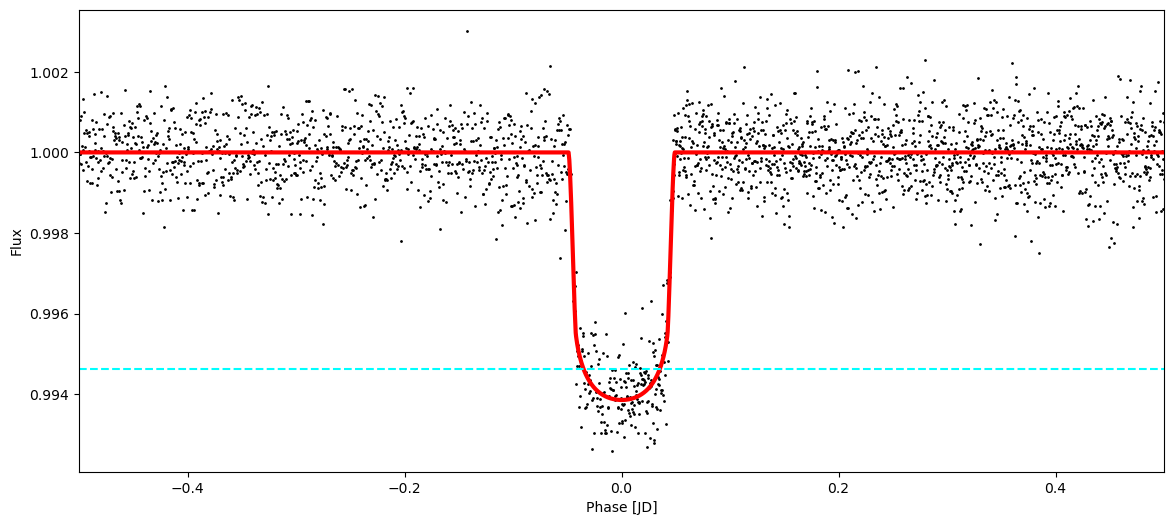

In [14]:
# different planet
# inject_P - period of the planet
# inject_RP is the radius of the planet


inj_RP2=4
inj_P2 = 7 


injected_LC2,injected_model_LC2,qld2 = transit_injection(fake_time=t,fake_flux=flux,fake_flux_err=fluxerr,
                                 inject_P=inj_P2,inject_RP=inj_RP2, inject_T0=t[0], 
                                 RS=R_star, MS=M_star )


#### Function: Take a window size in units of days; outputs how many data points are given in a certain cadence in the data


**What is it doing?** 

1. It first calculates the cadence (how seperated in time are each data points are on average, i.e. 30-minute cadence for TESS

2. It can take your desired window size then calculate how many data points happen. It is useful because the SB filter requires a window size in units of the number of points. However, Wotan requires a window size in units of time. If you want to use the same window size for both, this function can help you do this.

In [15]:
def convert_window_size_in_days_to_points(window_size_in_days,time):
    '''
    This function converts a window size into a
    window size in number of data points, based on the cadence of
    timestamps in input time array.
    Input Parameters
    ----------
    window_size_in_days : float
    Input window size in units of days
    time : array
    An array of timestamps from TESS observations.
    Returns
    -------
    * Npts : Number of data points corresponding
    to input window sizes
    '''
    cad = np.nanmedian(np.diff(time))
    
    def round_up_to_odd(f):
        return int(np.ceil(f) // 2 * 2 + 1)
    
    Npts = round_up_to_odd(int((window_size_in_days)/cad))
    return Npts

In [16]:
print(np.nanmedian(np.diff(t))) # raw data has units of days

0.0013889605179429054


In [17]:
# cadence data

print(24 * 60 * np.nanmedian(np.diff(t))) # units of minutes
                                        # there is a data point collected every half of minute

2.000103145837784


In [18]:
# window size for one hour

window = 1 / 24

# how many data points are given in a given hour?

convert_window_size_in_days_to_points(window, t)

29

#### Test

* A series of 8 TESS experiments for both light curves in total


**Four experiments are**

1. Using a SG filter with a window size of 1 day or 24 hours 
2. Using a SG filter with a window size of 1 hour
3. Using a Wotan filter with a window size of 1 day or 24 hours
4. Using a Wotan filter with a window size of 1 hour


[6/11] Completed: LC1 - 3 and 4

In [19]:
def detrend(lc, window_length, filter_type, return_trend = True):
    '''
    Detrending light curves using wotan
    
    Inputs
    ------
    lc is the light curve object 
    
    window_length is the window size used for detrending (units of time)
    
    filter_type is a string that takes either Wotan or SG filters as an input
    
    return_trend if you want a trendline to be produced as an array
    
    
    Returns
    -------
    newlc returns the light curve objec with the detrended flux values
    
    trendlc returns the output of the trendline as an array
    
    '''
    
    if filter_type == "Wotan":
        from wotan import flatten
        import numpy as np

        flatten_lc, trend_lc = flatten(lc.time.value, lc.flux.value, 
                                       window_length = window_length, return_trend = return_trend)

        newlc = lk.LightCurve(time = lc.time.value, flux = flatten_lc, 
                              flux_err = lc.normalize().flux_err.value)
    if filter_type == "SG":
        npoints = convert_window_size_in_days_to_points(window_length, lc.time.value)
        newlc, trend_lc = lc.flatten(window_length = npoints, return_trend = return_trend)
        trend_lc = trend_lc.flux.value # SG model
        
    return newlc, trend_lc

In [20]:
import os
def transit_searching_bls(lc, trend_lc, period_minimum, period_maximum, n_periods, filename,
                          frequency_factor = 500,savepath=os.getcwd()+'/',
                          injected_RP_in_earth_radii=None, R_star=None):
    '''
    search light curves for periodic transits using BLS then extract the best-fit BLS module parameters 
    (period, epoch, duration, depth), then with those paramters, it will face fold them
    
    
    Inputs
    -----
    lc = our light curve object
    
    trend_lc = shows the red line
    
    period_minimum = minimum period in our transit search
    
    period_maximum = maximun period in our transit search
    
    n_periods = the number of periods in our period grid (combinations of period related to BLS)
    
    filename is the name of our BLS transit search figure
    
    frequency_factor = 500 controls the spacing of the periods in our period grid
    
    savepath = location on machine where data products are saved to
    
    injected_RP_in_earth_radii = planet radius used for injected light curves  [in units of earth radii]
    
    R_star = stellar radius of star light curve is measured from [in units of solar radii]
    
    '''
    
    import numpy as np
    
    import matplotlib.gridspec as gridspec

    figure = plt.figure(figsize = (10, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = figure.add_subplot(gs[0:1, 0:2]) # light curve w/ the trend line
    ax2 = figure.add_subplot(gs[1:, 0:1]) # BLS power graph
    ax3 = figure.add_subplot(gs[1:, 1:2]) # phase folded light curve
    
    # manually creating the plots
    ax1.scatter(lc.time.value - 2457000, lc.flux.value, color = 'black', s = 0.7)
    ax1.plot(lc.time.value - 2457000, trend_lc / np.nanmedian(trend_lc), color = 'r')
    ax1.set_xlabel('Time [TESS JD]')
    ax1.set_ylabel('Normalized Flux')
    
    period_grid = np.linspace(period_minimum, period_maximum, n_periods)
    
    # lightkurve
    bls = lc.to_periodogram(method = 'bls', period = period_grid, 
                            frequency_factor = frequency_factor)
    
    # for the bls power, calculating SDE and converting it from power
    bls_power = bls.power
    bls_sde = (bls_power - np.nanmean(bls_power)) / np.nanstd(bls_power)

    
    #bls.plot(ax = ax2, color = 'black', linewidth = 2);  # power spectrum plot
    
    # new power spectrum plot
    ax2.plot(1 / bls.frequency, bls_sde, color = 'black', linewidth = 2);
    
    period = bls.period_at_max_power
    
    # Plotting the strongest lines in the power spectrum plot and the harmonics
    ax2.axvline(x = period.value, color = 'r', linestyle = '-', alpha = 0.5)
    for i in range(2, 5):
        ax2.axvline(x = period.value * i, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
        ax2.axvline(x = period.value / i, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
    
    ax2.set_xlabel('Period [d]')
    ax2.set_ylabel('SDE')
    
    ax2.set_xlim(np.nanmin(period_grid) - 1, np.nanmax(period_grid) + 1)
    
    epoch = bls.transit_time_at_max_power
    
    duration = bls.duration_at_max_power
    
    depth = bls.depth_at_max_power  # units of light curve
    
    #calculate measured planet radius
    import astropy.units as u
    R_planet = np.sqrt(depth) * R_star * ( u.R_sun.to(u.cm) / u.R_earth.to(u.cm) )    
    
    #calculating best-fit BLS model
    BLS_lc = bls.get_transit_model(period=period,
                                   transit_time=epoch,
                                   duration=duration)
    
    
    folded_lc = lc.fold(period = period, epoch_time = epoch) # epoch is the reference time for BLS
    BLS_folded_lc = BLS_lc.fold(period = period, epoch_time = epoch)
    folded_lc.scatter(ax = ax3, color = 'black');
    BLS_folded_lc.plot(ax = ax3,  color = 'cyan',linestyle='-',lw=3);    
    ax3.set_ylabel('Normalized Flux')
    
    ax3.set_xlim(-4 * duration.value, 4 * duration.value) # negative numbers are yesterdays, 0 is present, 
    ax3.axhline(y = 1 - depth, color = 'r')                            # and positive numbers are tomorrows
    ax3.axvline(x = 0 - duration.value, color = 'r')
    ax3.axvline(x = 0 + duration.value, color = 'r')
    
    
    # if injected_RP_in_stellar_radii is provided as an input,
    # plot the predicted transit depths as horizontal lines
    if type(injected_RP_in_earth_radii) != type(None):    
        ax1.axhline(y=1-predicted_transit_depth(injected_planet_radius=injected_RP_in_earth_radii,
                                   R_star=R_star,planet_units='earth'),color='cyan',linestyle='--')
        ax3.axhline(y=1-predicted_transit_depth(injected_planet_radius=injected_RP_in_earth_radii,
                                   R_star=R_star,planet_units='earth'),color='cyan',linestyle='--')
        
    # add text over power spectrum and phase-folded LC to show best-fit TLS params
    ax2.set_title('BLS Period = ' + str( np.round ( period , 3) ) +' days' )
    ax3.set_title('BLS Planet Radius = ' + str( np.round ( R_planet , 3) ) +' $R_{\oplus}$' )        
    
    gs.tight_layout(figure, pad = 1)
    figure.savefig(savepath+filename, bbox_inches = "tight")
    plt.show();
    
    df = pd.DataFrame({"Period": period, "Epoch": epoch, "Duration": duration, 
                       "Depth": depth,'Radius':R_planet}, index = [0])
    
    df.to_csv(savepath+filename[:-4] + ".csv")
    
    return period, epoch, duration, depth

In [21]:
import os
def transit_searching_tls(lc, trend_lc, filename, use_threads=4,oversampling_factor = 9, duration_grid_step = 1.1,
                          savepath=os.getcwd()+'/',
                          injected_RP_in_earth_radii=None,R_star=None,M_star=None,
                          limb_darkening_coefficients=None):   
    '''
    search light curves for periodic transits using TLS then extract the best-fit TLS module parameters 
    (period, epoch, duration, depth), then with those paramters, it will face fold them
    
    
    Inputs
    -----
    lc = our light curve object
    
    trend_lc = shows the red line
    
    filename is the name of our TLS transit search figure
    
    oversampling_factor is an integer to avoid that the true period falls in between trial periods and is missed
    
    duration_grid_step is the width between subsequent trial, each subseqeunt trail duration 
    is longer by 10% for 1.1
    
    savepath = location on machine where data products are saved to
    
    injected_RP_in_earth_radii = planet radius used for injected light curves  [in units of earth radii]
    
    R_star = stellar radius of star light curve is measured from [in units of solar radii]
    
    M_star = stellar mass of star light curve is measured from [in units of solar masses]
    
    limb_darkening_coefficients = values for quadratic limb darkening law; input should be list [a,b]
    
    '''
        
    from transitleastsquares import transitleastsquares
    import numpy as np
    
    # lightkurve objects
    time = lc.time.value # time arrays
    flux = lc.flux.value # flux arrays
    uncertainties = lc.flux_err.value # flux error arrays
    
    import matplotlib.gridspec as gridspec

    figure = plt.figure(figsize = (10, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = figure.add_subplot(gs[0:1, 0:2]) # light curve w/ the trend line
    ax2 = figure.add_subplot(gs[1:, 0:1]) # BLS power graph
    ax3 = figure.add_subplot(gs[1:, 1:2]) # phase folded light curve
    
    # light curve plot
    ax1.scatter(lc.time.value - 2457000, lc.flux.value, color = 'black', s = 0.7)
    ax1.plot(lc.time.value - 2457000, trend_lc / np.nanmedian(trend_lc), color = 'r')
    ax1.set_xlabel('Time [TESS JD]')
    ax1.set_ylabel('Normalized Flux')
    
    # TLS Plot
    if type(limb_darkening_coefficients)!= type(None):
        qld= limb_darkening_coefficients
        R_star_min = R_star*0.05 #THIS IS AN ASSUMPTION
        R_star_max = R_star*0.05 #THIS IS AN ASSUMPTION
        
        M_star_min = M_star*0.05 #THIS IS AN ASSUMPTION
        M_star_max = M_star*0.05 #THIS IS AN ASSUMPTION        
        
        tls = transitleastsquares(t, flux) # model
        results = tls.power(oversampling_factor = oversampling_factor, 
                            duration_grid_step = duration_grid_step, 
                            R_star_min=R_star-R_star_min, R_star_max=R_star+R_star_max,R_star=R_star,\
                            M_star_min=M_star-M_star_min, M_star_max=M_star+M_star_max,M_star=M_star,\
                            u=qld,
                            use_threads = use_threads)                
    else:
        tls = transitleastsquares(t, flux) # model
        results = tls.power(oversampling_factor = oversampling_factor, 
                            duration_grid_step = duration_grid_step, 
                            use_threads = use_threads)

    # power spectrum plot
    ax2.plot(results.periods, results.power, color = 'black') # results.periods is the period_grid
    ax2.set_xlabel('Period (days)')
    ax2.set_ylabel('SDE') # unitless
    
    # parameters
    period = results.period # in units of days
    
    # Plotting the strongest lines in the power spectrum plot and the harmonics
    ax2.axvline(x = period, color = 'r', linestyle = '-', alpha = 0.5)
    for i in range(2, 5):
        ax2.axvline(x = period * i, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
        ax2.axvline(x = period / i, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
    
    ax2.set_xlim(np.nanmin(results.periods) - 1, np.nanmax(results.periods) + 1)
    
    
    epoch = results.T0 # in units of light curve (time stamps)
    duration = results.duration # in units of days
    depth = 1 - results.depth  # in units of light curve (time stamps) - rescaling the depth
    
    #calculate measured planet radius
    import astropy.units as u
    R_planet = np.sqrt(depth) * R_star * ( u.R_sun.to(u.cm) / u.R_earth.to(u.cm) )
    
    #calculate best-fit TLS model
    TLS_model_time = results.model_lightcurve_time
    TLS_model = results.model_lightcurve_model
    TLS_lc = lk.LightCurve(time=TLS_model_time,flux=TLS_model,flux_err=np.ones_like(np.nanstd(TLS_model)))
    
    # folding light curve
    folded_lc = lc.fold(period = period, epoch_time = epoch) # epoch is the reference time for BLS
    TLS_folded_lc = TLS_lc.fold(period = period, epoch_time = epoch)
    folded_lc.scatter(ax = ax3, color = 'black');
    TLS_folded_lc.plot(ax = ax3, color = 'cyan',linestyle='-',lw=3);    
    ax3.set_ylabel('Normalized Flux')
    
    ax3.set_xlim(-4 * duration, 4 * duration) # negative numbers are yesterdays, 0 is present, 
    ax3.axhline(y = 1 - depth, color = 'r')                            # and positive numbers are tomorrows
    ax3.axvline(x = 0 - duration, color = 'r')
    ax3.axvline(x = 0 + duration, color = 'r')
    
    
    # if injected_RP_in_stellar_radii is provided as an input,
    # plot the predicted transit depths as horizontal lines
    if type(injected_RP_in_earth_radii) != type(None):    
        ax1.axhline(y=1-predicted_transit_depth(injected_planet_radius=injected_RP_in_earth_radii,
                                   R_star=R_star,planet_units='earth'),color='cyan',linestyle='--')
        ax3.axhline(y=1-predicted_transit_depth(injected_planet_radius=injected_RP_in_earth_radii,
                                   R_star=R_star,planet_units='earth'),color='cyan',linestyle='--')
    
    # add text over power spectrum and phase-folded LC to show best-fit TLS params
    ax2.set_title('TLS Period = ' + str( np.round ( period , 3) ) +' days' )
    ax3.set_title('TLS Planet Radius = ' + str( np.round ( R_planet , 3) ) +' $R_{\oplus}$' )
    
    figure.tight_layout(pad = 1)
    
    figure.savefig(savepath+filename[:-4] + "_tls.png", bbox_inches = "tight")
    
    plt.show();
    
    df = pd.DataFrame({"Period": period, "Epoch": epoch, "Duration": duration, 
                       "Depth": depth,'Radius':R_planet}, index = [0])
    
    df.to_csv(savepath+filename[:-4] + "_tls.csv")
    
    return period, epoch, duration, depth

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using all 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:21<00:00


Searching for best T0 for period 7.00001 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2051.75it/s]


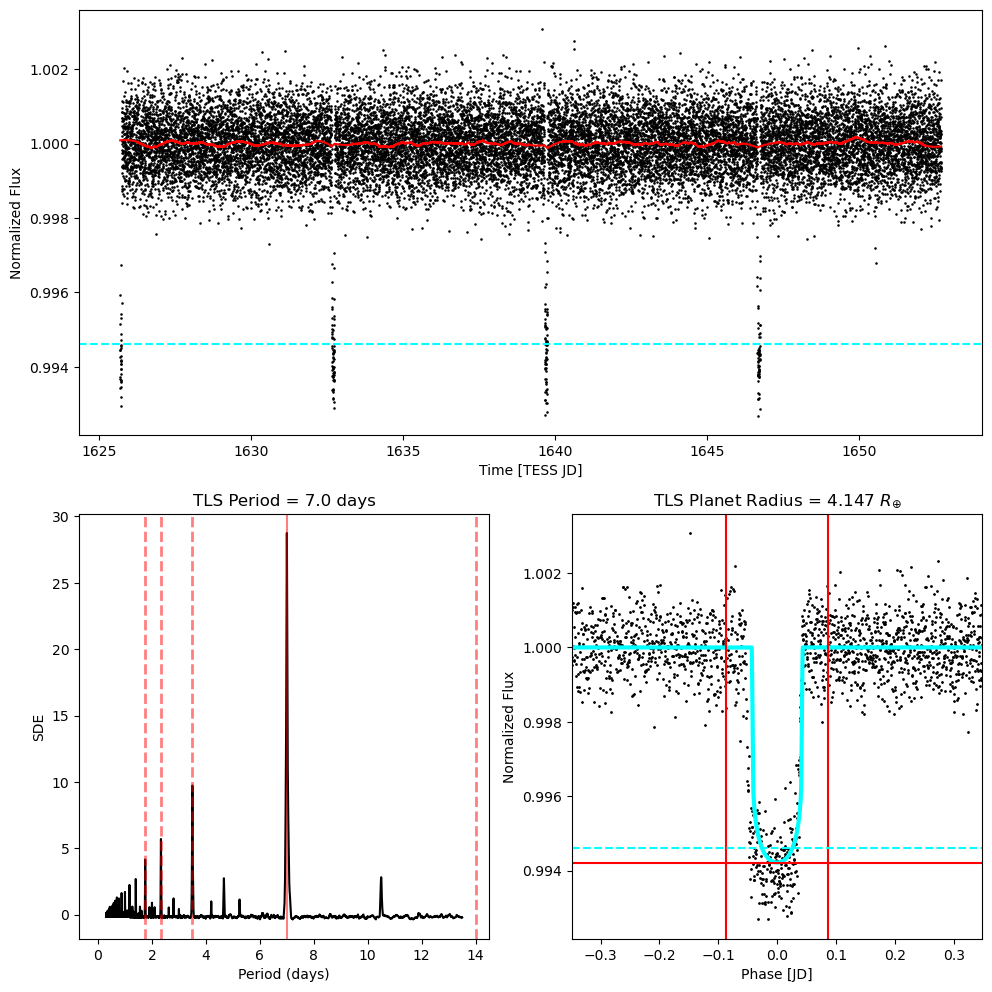

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 7373 periods from 0.602 to 13.5 days
Using all 10 CPU threads


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 7373/7373 periods | 00:31<00:00


Searching for best T0 for period 6.99971 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2147.24it/s]


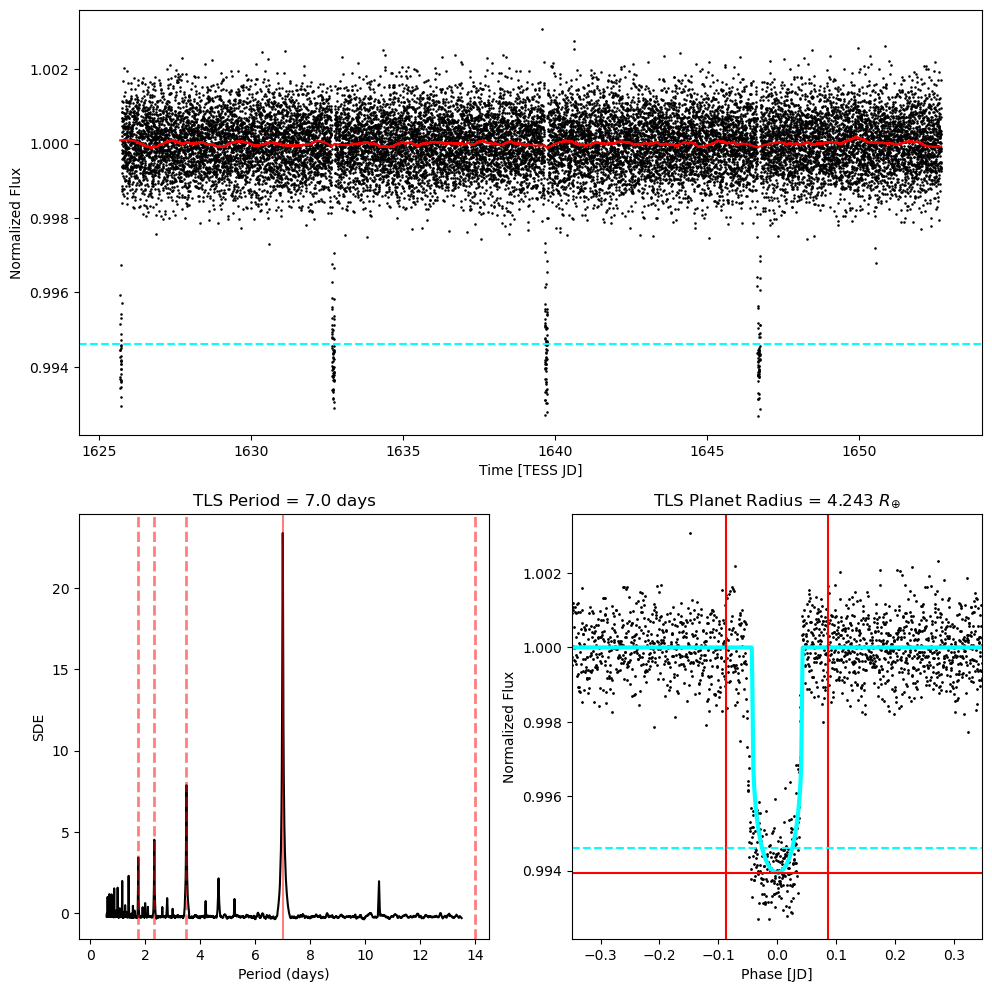

In [22]:
# For TLS


newlc2_W1_TLS, trend_lc2_W1_TLS = detrend(lc = injected_LC2, window_length = 1, 
                                      filter_type = "SG", return_trend = True)


#slightly more accurate
period, epoch, duration, depth = transit_searching_tls(lc = newlc2_W1_TLS, trend_lc = trend_lc2_W1_TLS,
                                                       filename = "LC2_TestSG127D_TLS.png",
                                                       use_threads=10,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)


#compare to TLS without M_star & qld

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_W1_TLS, trend_lc = trend_lc2_W1_TLS,
                                                       filename = "LC2_TestSG127D_TLS.png",
                                                       use_threads=10,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=None,
                                                       limb_darkening_coefficients=None)



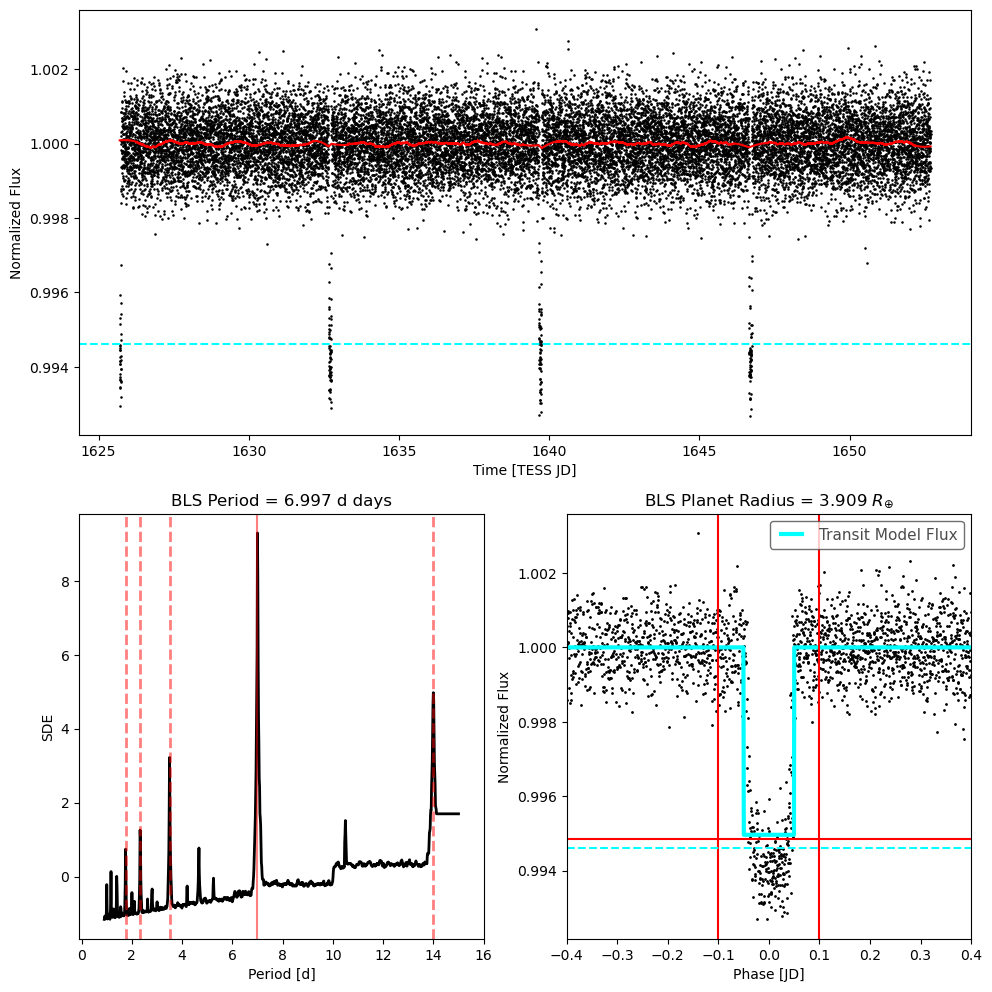

In [23]:
# For BLS


newlc2_W1_BLS, trend_lc2_W1_BLS = detrend(lc = injected_LC2, window_length = 1, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc2_W1_BLS, trend_lc = trend_lc2_W1_BLS, 
                                                       period_minimum = 0.9, period_maximum = 15, 
                                                       n_periods = 1000, filename = "LC1_TestW1.png", 
                                                       frequency_factor = 500,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star)


In [24]:
# print(newlc1_W1.time.value - 2457000) # in units of TESS JD

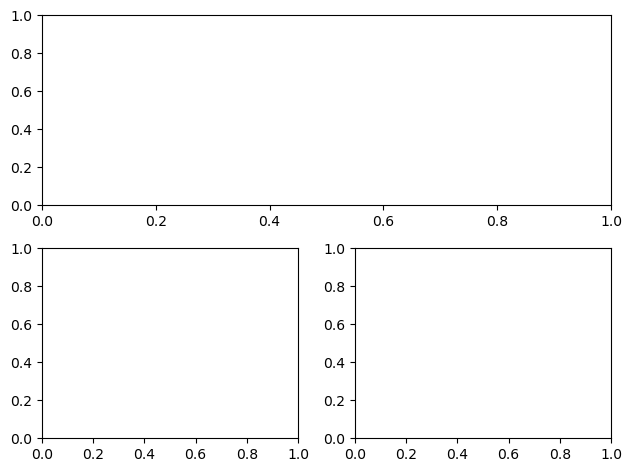

In [25]:
import matplotlib.gridspec as gridspec

figure = plt.figure()
gs = gridspec.GridSpec(2, 2)

ax1 = figure.add_subplot(gs[0:1, 0:2])
ax2 = figure.add_subplot(gs[1:, 0:1])
ax3 = figure.add_subplot(gs[1:, 1:2])

gs.tight_layout(figure, pad = 1)

plt.show();

## Coding Challenge: Use transit_search_bls for 8 TESS experiments w/ the synthetic data

In [26]:
import os
# will create a directory whereever this notebook is run from
saveresults_path= os.getcwd()+'/experiment_1/' 
if not os.path.exists(saveresults_path):
    os.makedirs(saveresults_path)
# and will then create a sub-directory called experiment_1
print(saveresults_path)

/Users/daxfeliz/Desktop/Mentoring_Teaching/AMNH_REU/Madeline/experiment_1/


### Injected LC1

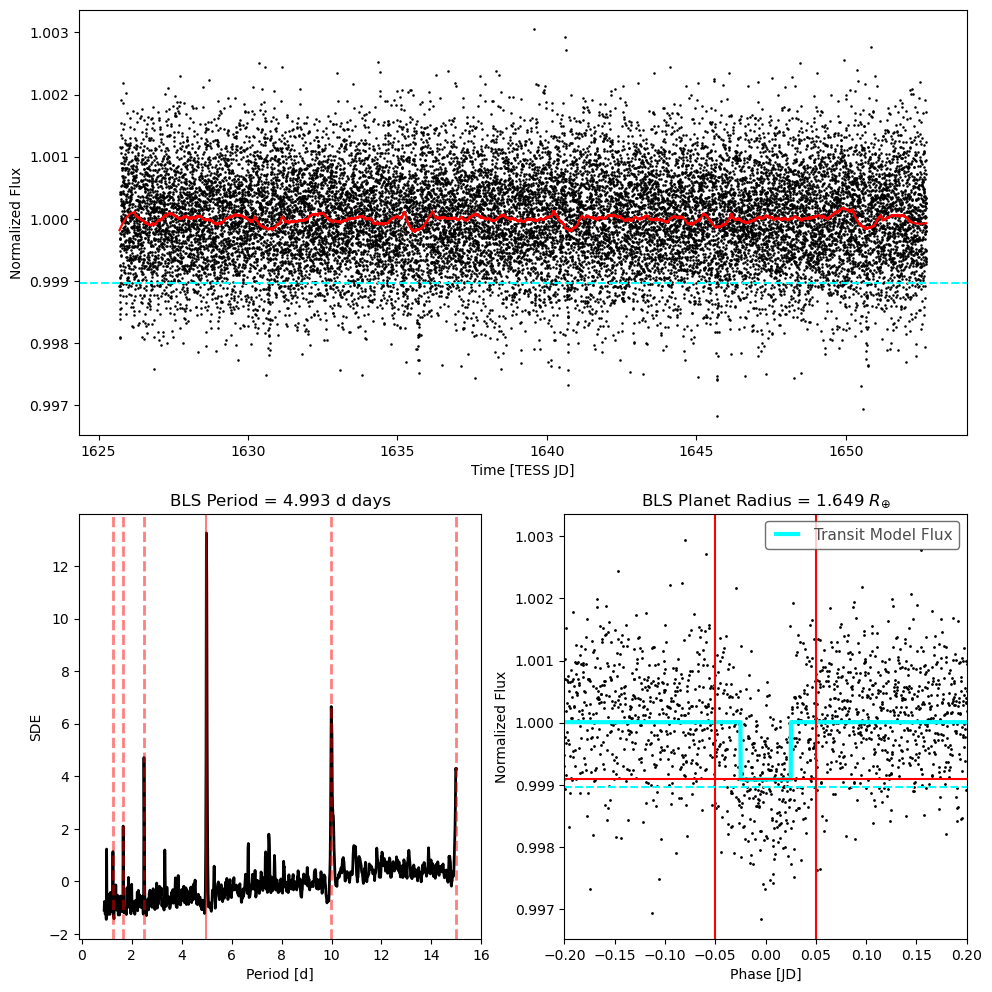

In [27]:
newlc1_SG1D_bls, trend_lc1_SG1D_bls = detrend(lc = injected_LC1, window_length = 1, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc1_SG1D_bls, trend_lc = trend_lc1_SG1D_bls, 
                                                       period_minimum = 0.9, period_maximum = 15, 
                                                       n_periods = 1000, filename = "LC1_TestSG1D_BLS.png", 
                                                       frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)

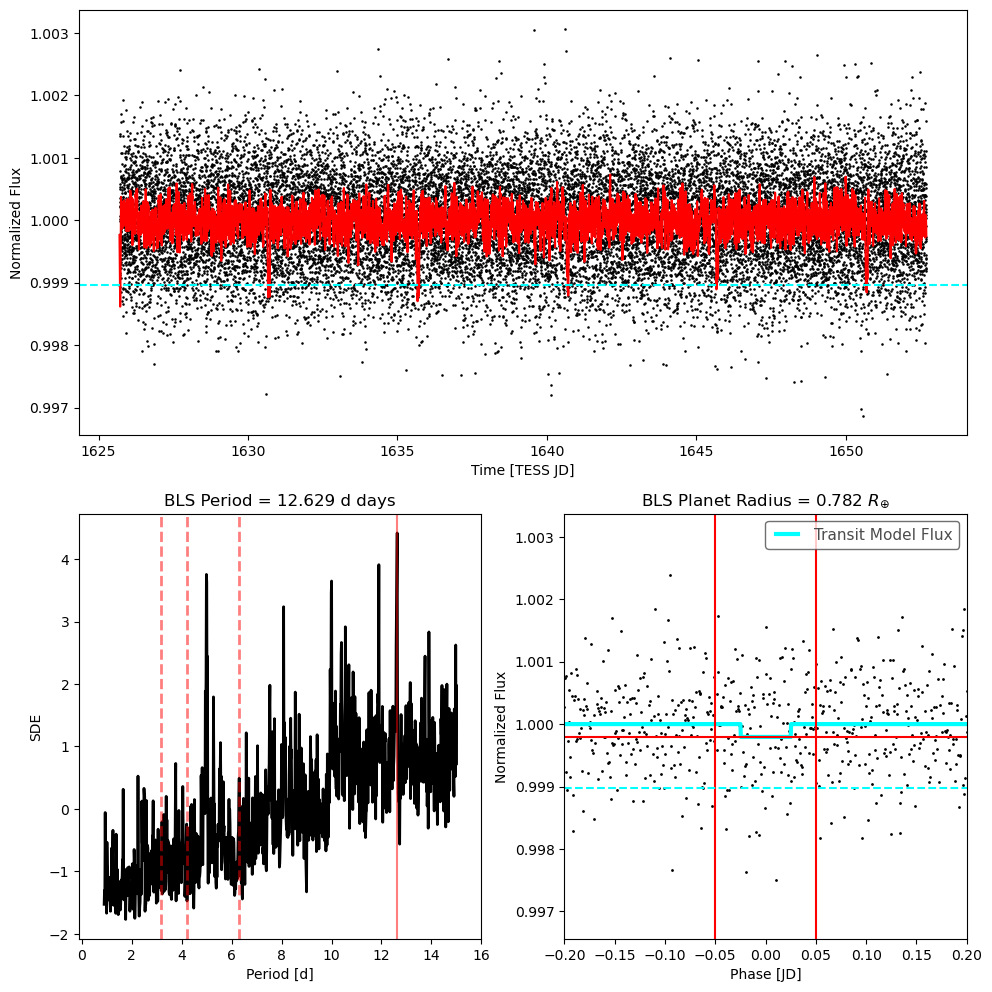

In [28]:
newlc1_SG1H_bls, trend_lc1_SG1H_bls = detrend(lc = injected_LC1, window_length = 1 / 24, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc1_SG1H_bls, trend_lc = trend_lc1_SG1H_bls,
                                                   period_minimum = 0.9, period_maximum = 15, 
                                                   n_periods = 1000, filename = "LC1_TestSG1H_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)

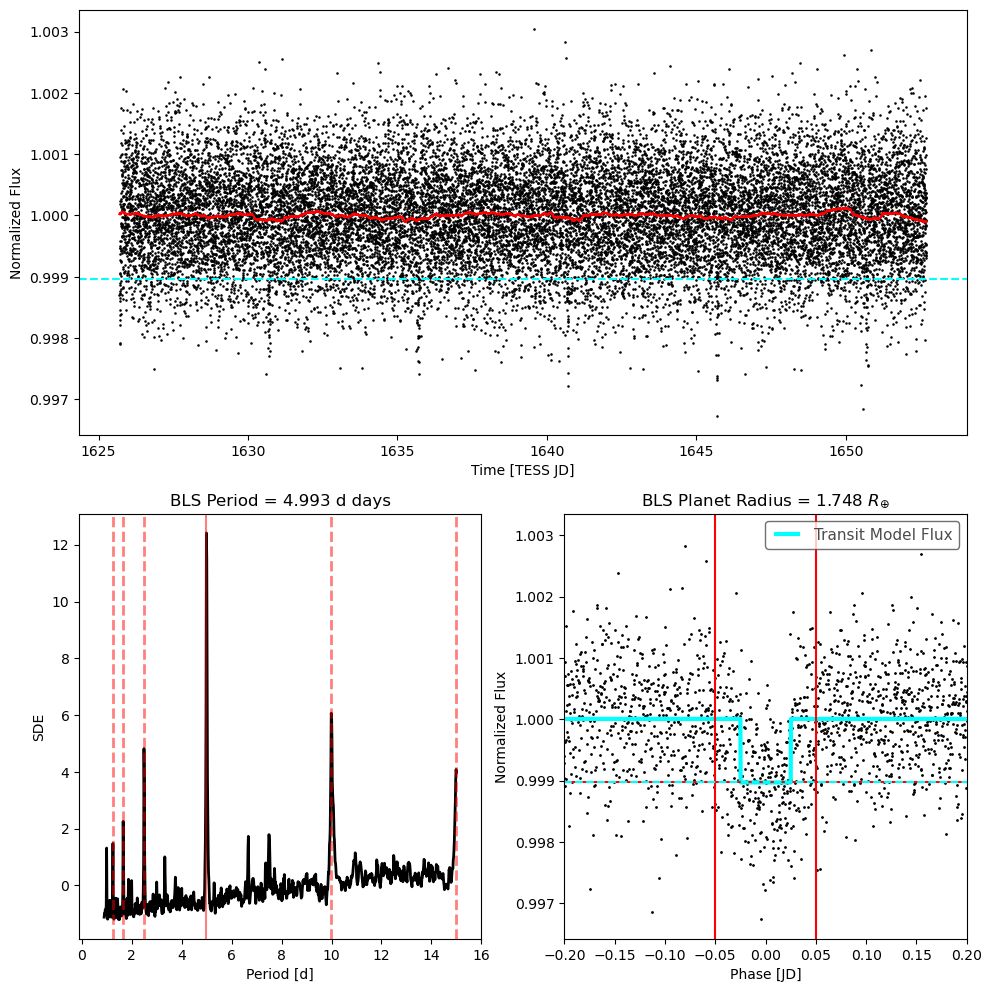

In [29]:
newlc1_W1D_bls, trend_lc1_W1D_bls = detrend(lc = injected_LC1, window_length = 1, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc1_W1D_bls, trend_lc = trend_lc1_W1D_bls,
                                                   period_minimum = 0.9, period_maximum = 15, 
                                                   n_periods = 1000, filename = "LC1_TestW1D_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)

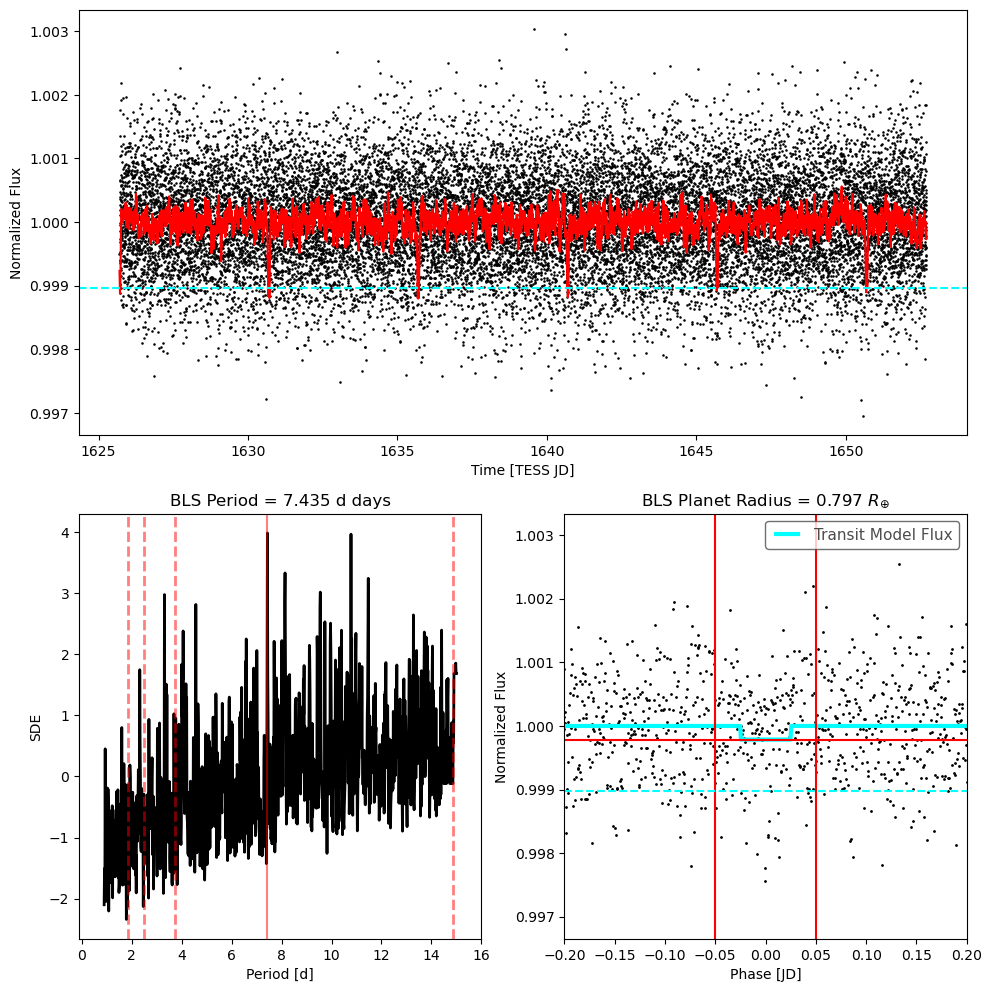

In [30]:
newlc1_W1H_bls, trend_lc1_W1H_bls = detrend(lc = injected_LC1, window_length = 1 / 24, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc1_W1H_bls, trend_lc = trend_lc1_W1H_bls,
                                                   period_minimum = 0.9, period_maximum = 15,
                                                   n_periods = 1000, filename = "LC1_TestW1H_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)

### Injected LC2

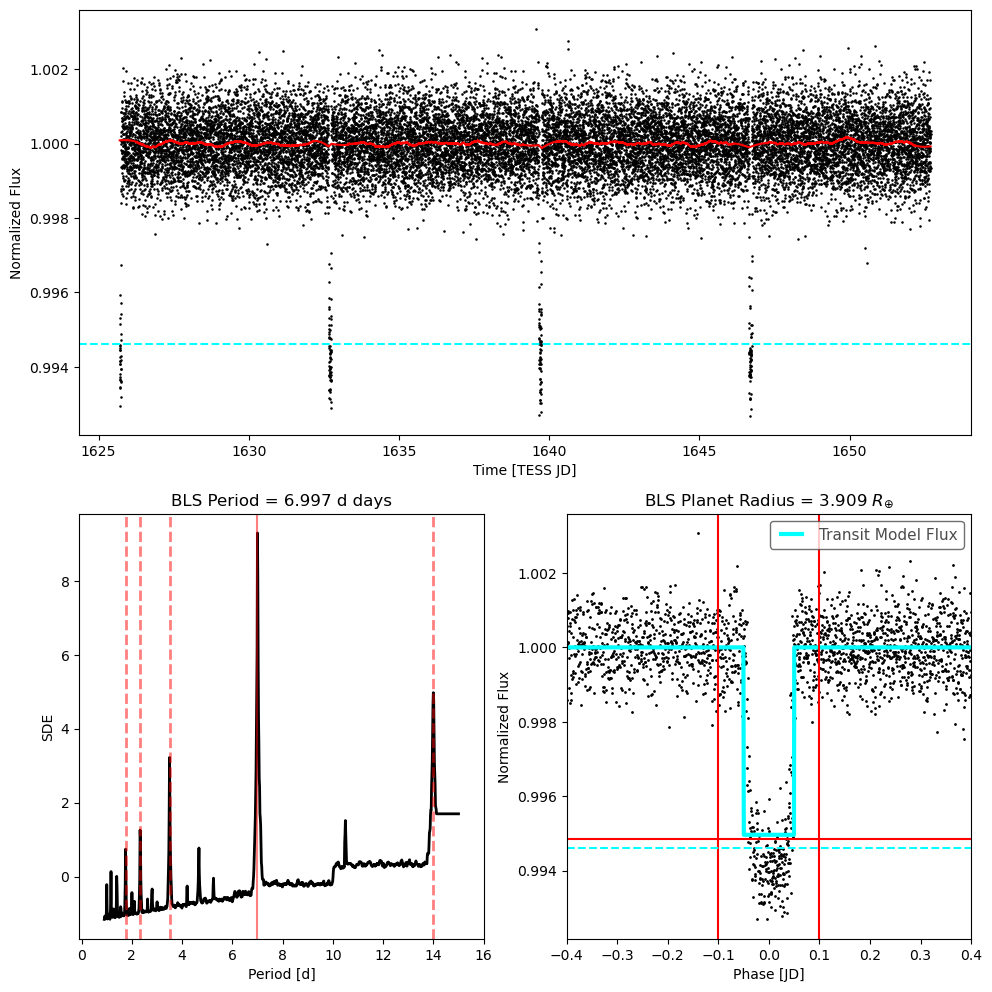

In [31]:
newlc2_SG1D_bls, trend_lc2_SG1D_bls = detrend(lc = injected_LC2, window_length = 1, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc2_SG1D_bls, trend_lc = trend_lc2_SG1D_bls,
                                                   period_minimum = 0.9, period_maximum = 15, 
                                                   n_periods = 1000, filename = "LC2_TestSG1D_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star)

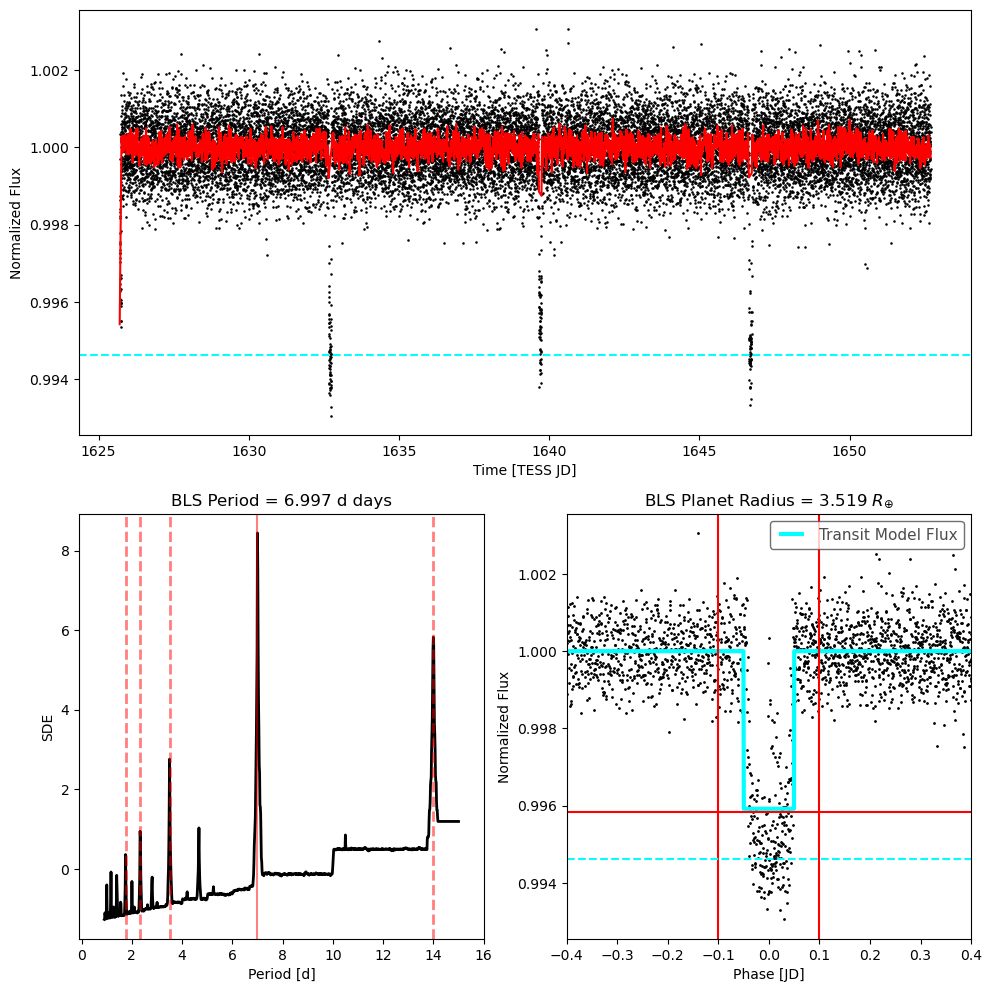

In [32]:
newlc2_SG1H_bls, trend_lc2_SG1H_bls = detrend(lc = injected_LC2, window_length = 1 / 24, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc2_SG1H_bls, trend_lc = trend_lc2_SG1H_bls,
                                                   period_minimum = 0.9, period_maximum = 15, 
                                                   n_periods = 1000, filename = "LC2_TestSG1H_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star)

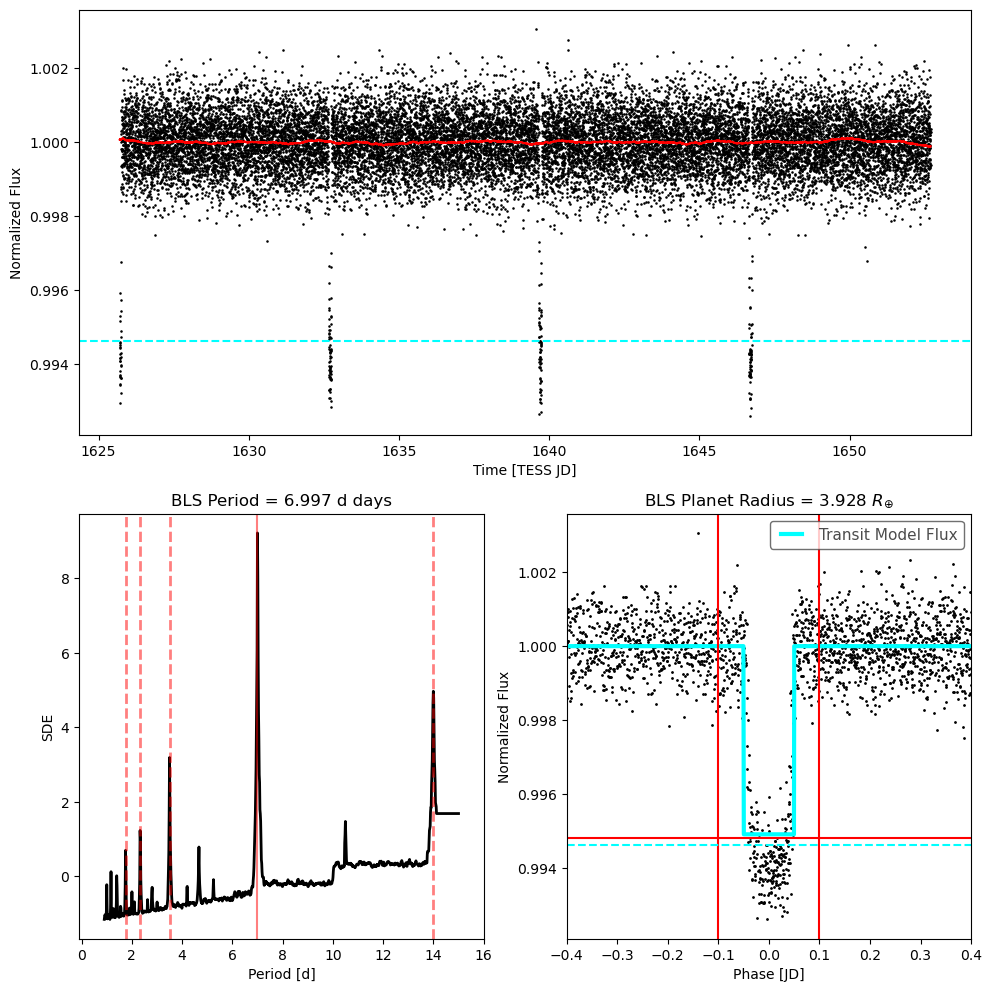

In [33]:
# The filter is not affecting the tranists; getting a strong signal; great example!

newlc2_W1D_bls, trend_lc2_W1D_bls = detrend(lc = injected_LC2, window_length = 1, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc2_W1D_bls, trend_lc = trend_lc2_W1D_bls,
                                                   period_minimum = 0.9, period_maximum = 15, 
                                                   n_periods = 1000, filename = "LC2_TestW1D_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star)

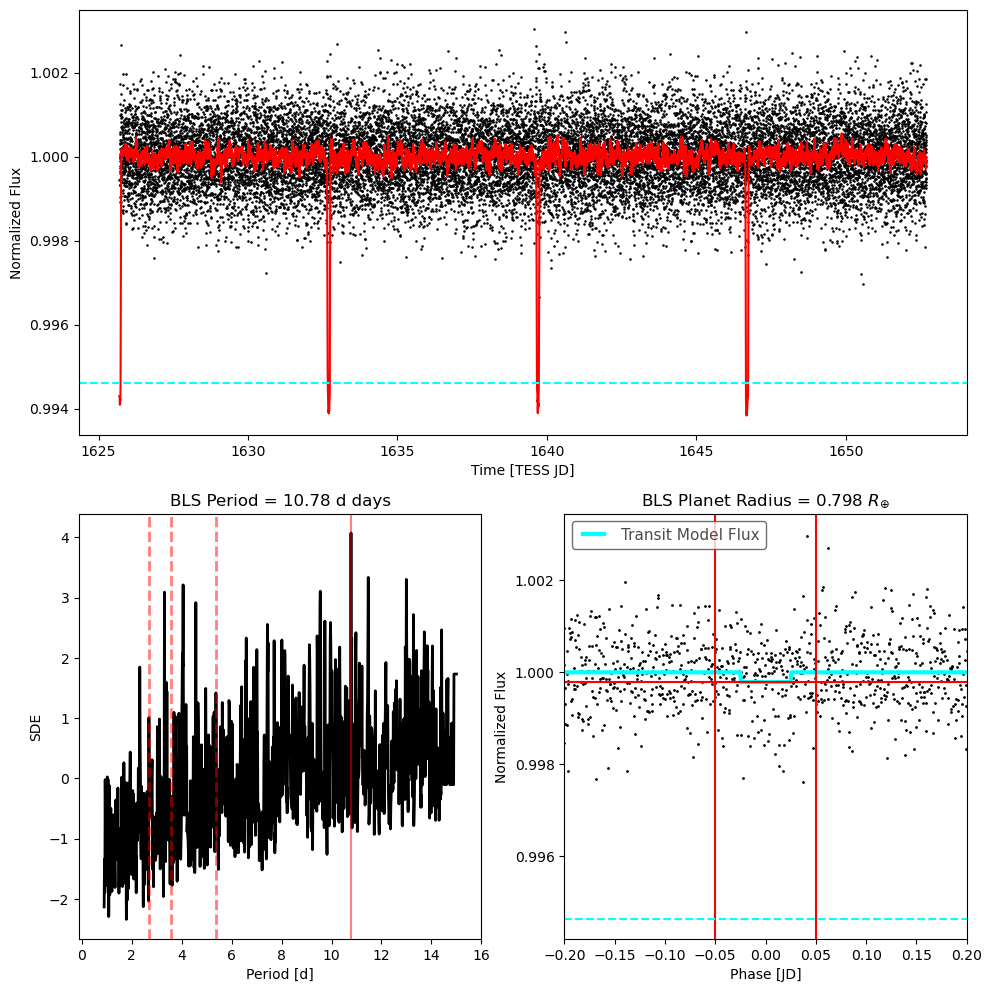

In [34]:
newlc2_W1H_bls, trend_lc2_W1H_bls = detrend(lc = injected_LC2, window_length = 1 / 24, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc2_W1H_bls, trend_lc = trend_lc2_W1H_bls, 
                                                   period_minimum = 0.9, period_maximum = 15, 
                                                   n_periods = 1000, filename = "LC2_TestW1H_BLS.png", 
                                                   frequency_factor = 500,savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star)

## Coding Challenge: Use transit_search_tls for 8 TESS experiments w/ the synthetic data

### Injected LC1

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:30<00:00


Searching for best T0 for period 5.00091 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5837/5837 [00:02<00:00, 2086.42it/s]


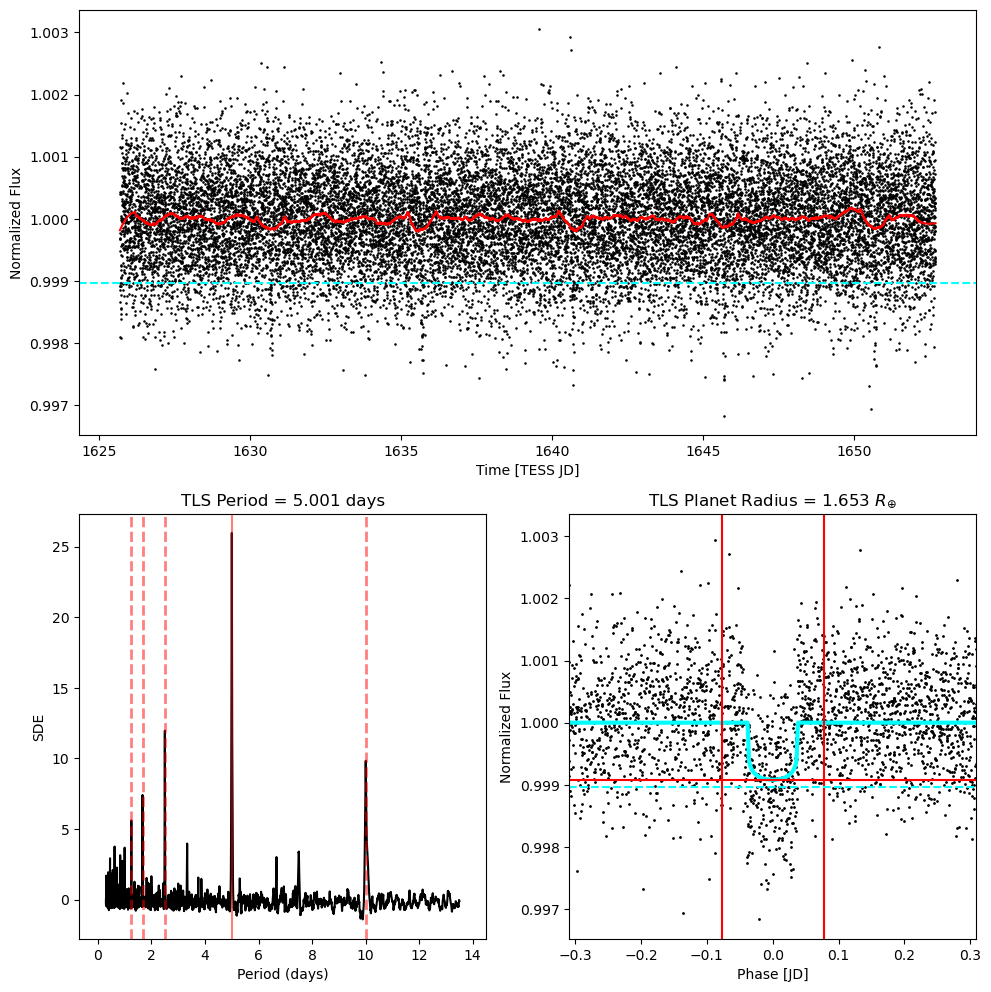

In [35]:
newlc1_SG1D_tls, trend_lc1_SG1D_tls = detrend(lc = injected_LC1, window_length = 1, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc1_SG1D_tls, trend_lc = trend_lc1_SG1D_tls,
                                                       filename = "LC1_TestSG1D_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld1)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:19<00:00


Searching for best T0 for period 5.00091 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5837/5837 [00:02<00:00, 2059.46it/s]


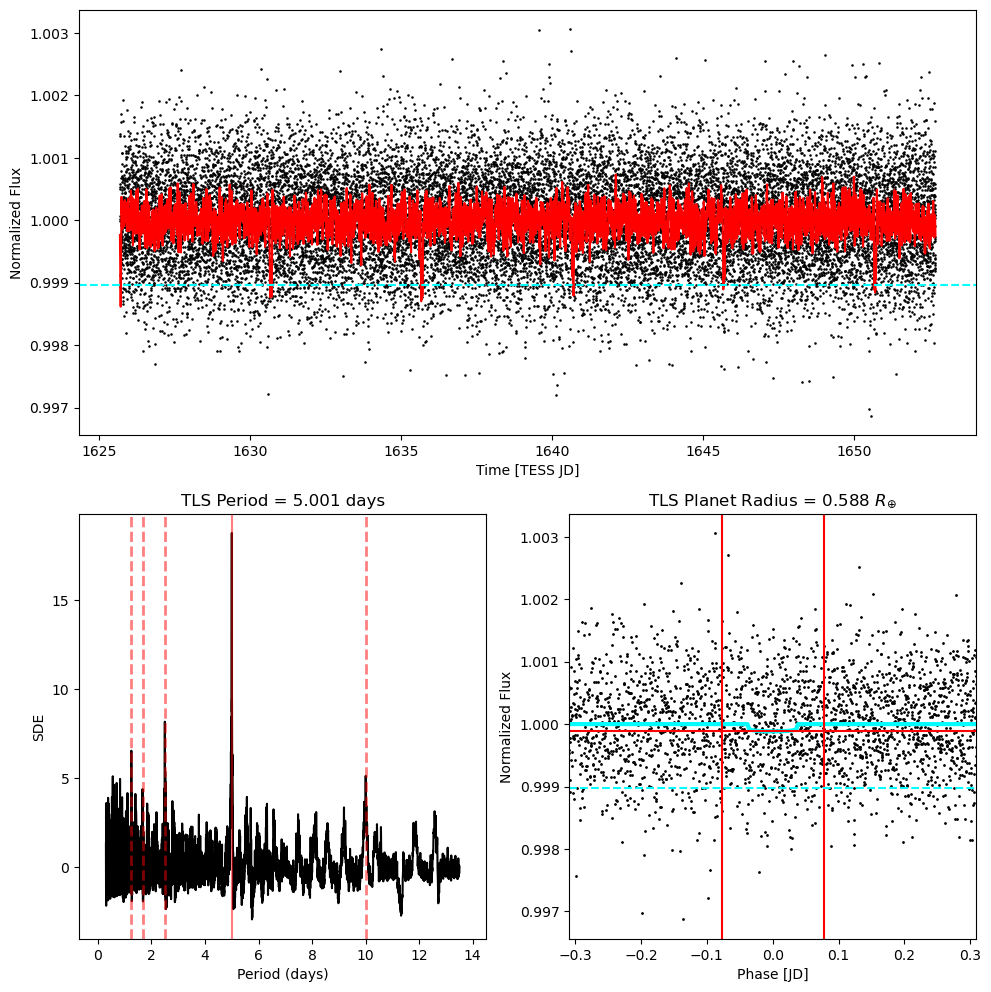

In [36]:
newlc1_SG1H_tls, trend_lc1_SG1H_tls = detrend(lc = injected_LC1, window_length = 1 / 24, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc1_SG1H_tls, trend_lc = trend_lc1_SG1H_tls,
                                                       filename = "LC1_TestSG1H_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld1)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:31<00:00


Searching for best T0 for period 5.00091 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5837/5837 [00:02<00:00, 2066.22it/s]


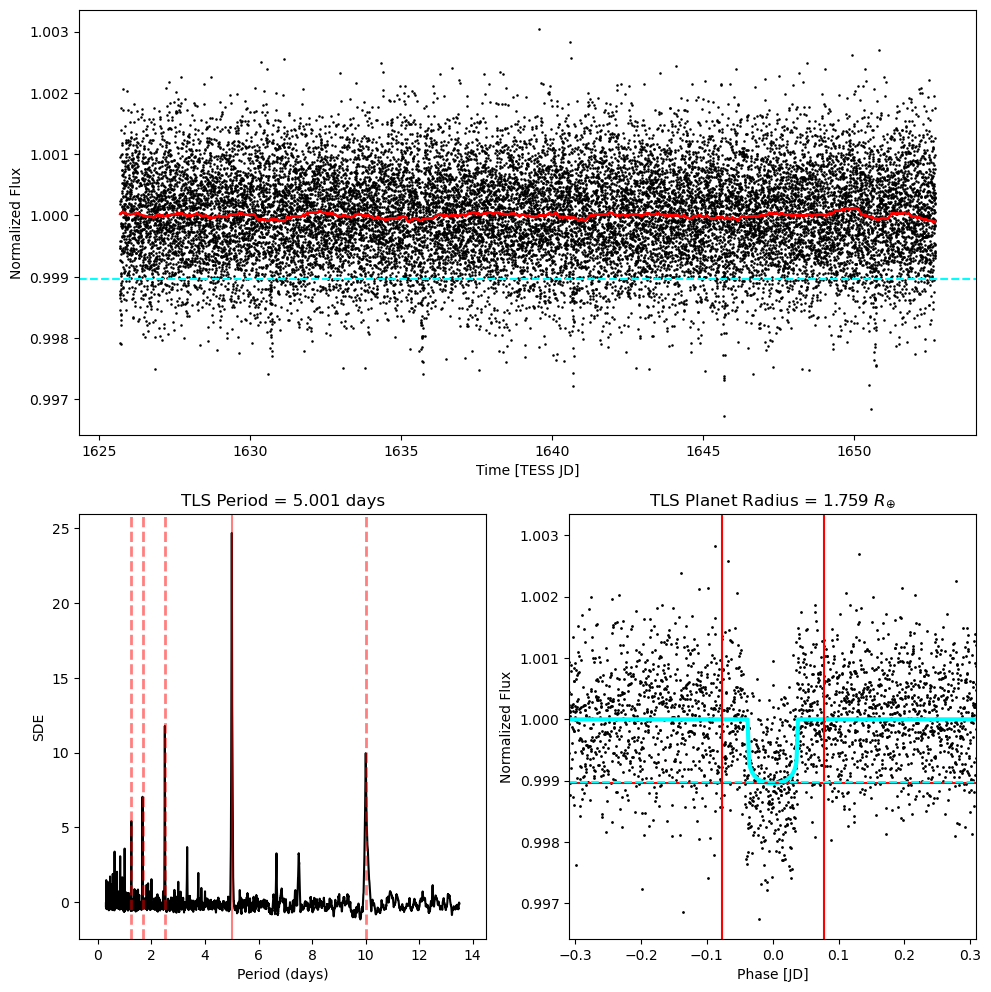

In [37]:
newlc1_W1D_tls, trend_lc1_W1D_tls = detrend(lc = injected_LC1, window_length = 1, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc1_W1D_tls, trend_lc = trend_lc1_W1D_tls,
                                                       filename = "LC1_TestW1D_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld1)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:26<00:00


Searching for best T0 for period 5.00091 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 5837/5837 [00:02<00:00, 2075.53it/s]


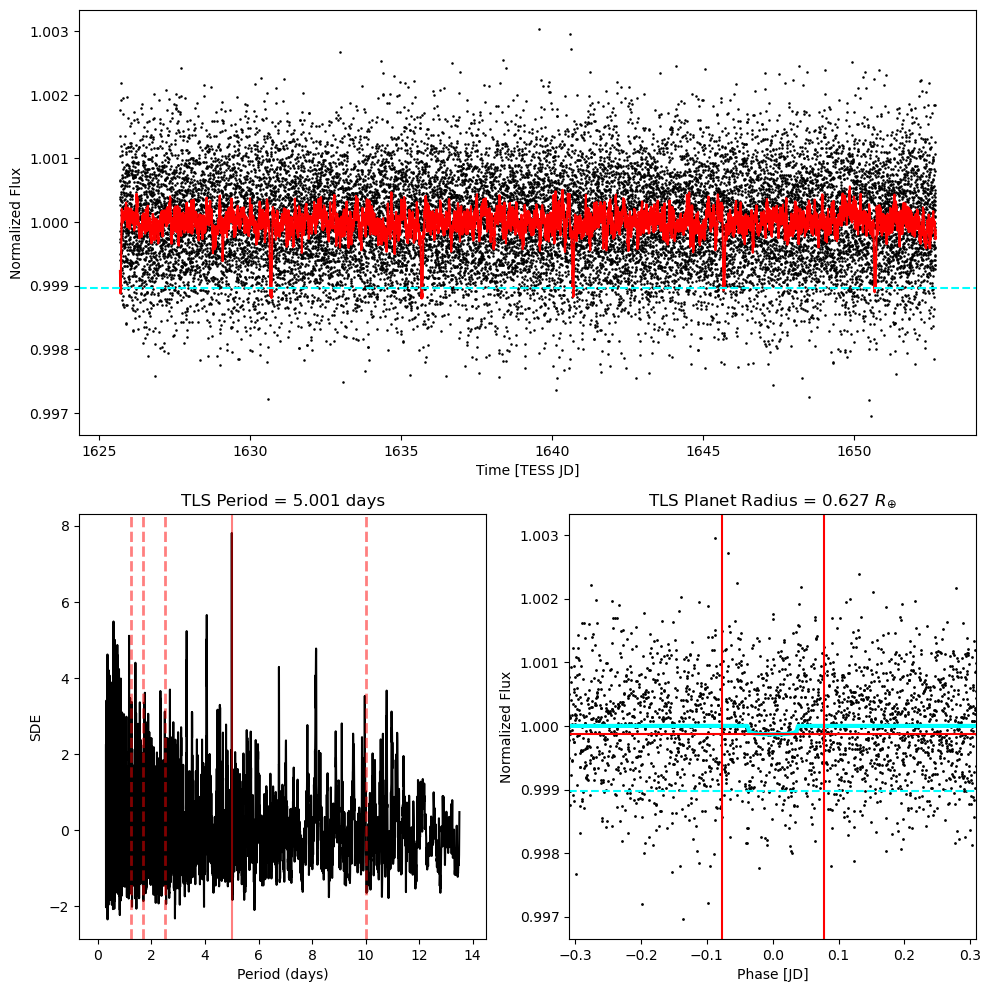

In [38]:
newlc1_W1H_tls, trend_lc1_W1H_tls = detrend(lc = injected_LC1, window_length = 1 / 24, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc1_W1H_tls, trend_lc = trend_lc1_W1H_tls,
                                                       filename = "LC1_TestW1H_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld1)

### Injected LC2

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:39<00:00


Searching for best T0 for period 7.00001 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2138.39it/s]


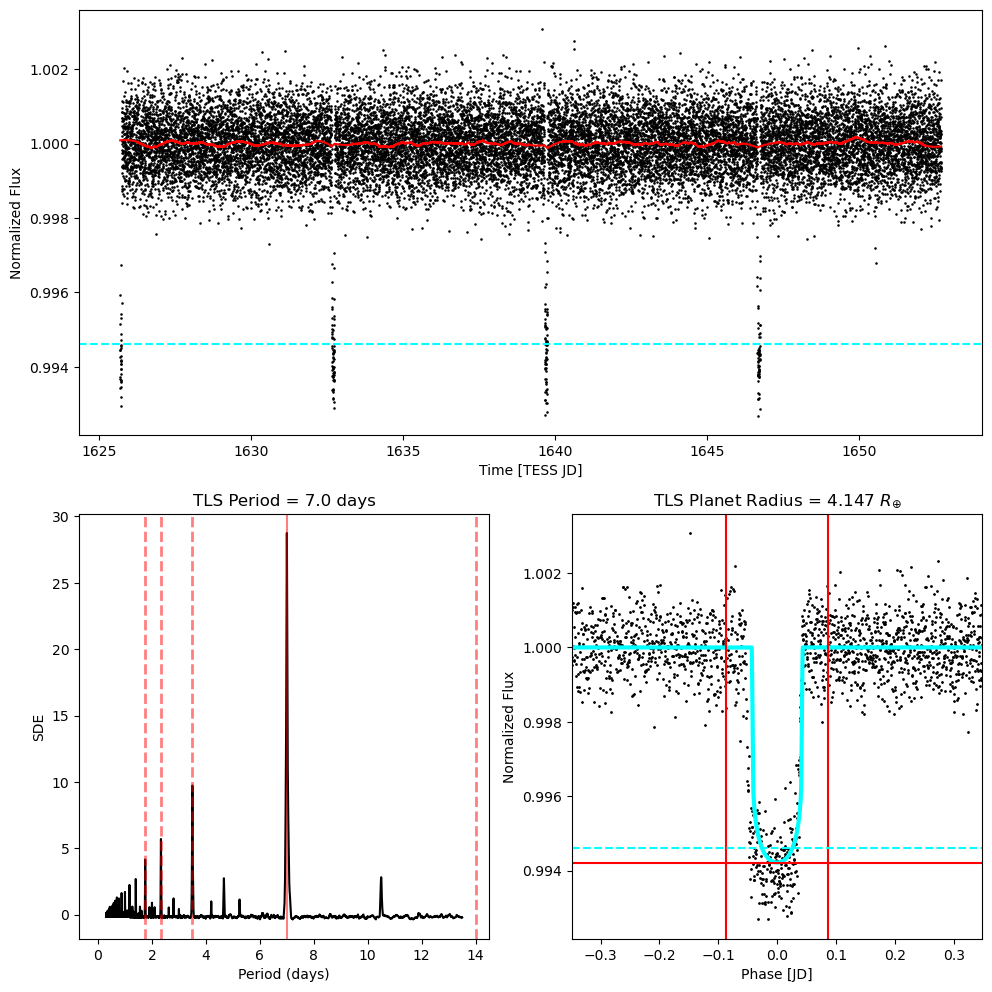

In [39]:
newlc2_SG1D_tls, trend_lc2_SG1D_tls = detrend(lc = injected_LC2, window_length = 1, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_SG1D_tls, trend_lc = trend_lc2_SG1D_tls,
                                                       filename = "LC2_TestSG1D_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:32<00:00


Searching for best T0 for period 7.00001 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2145.35it/s]


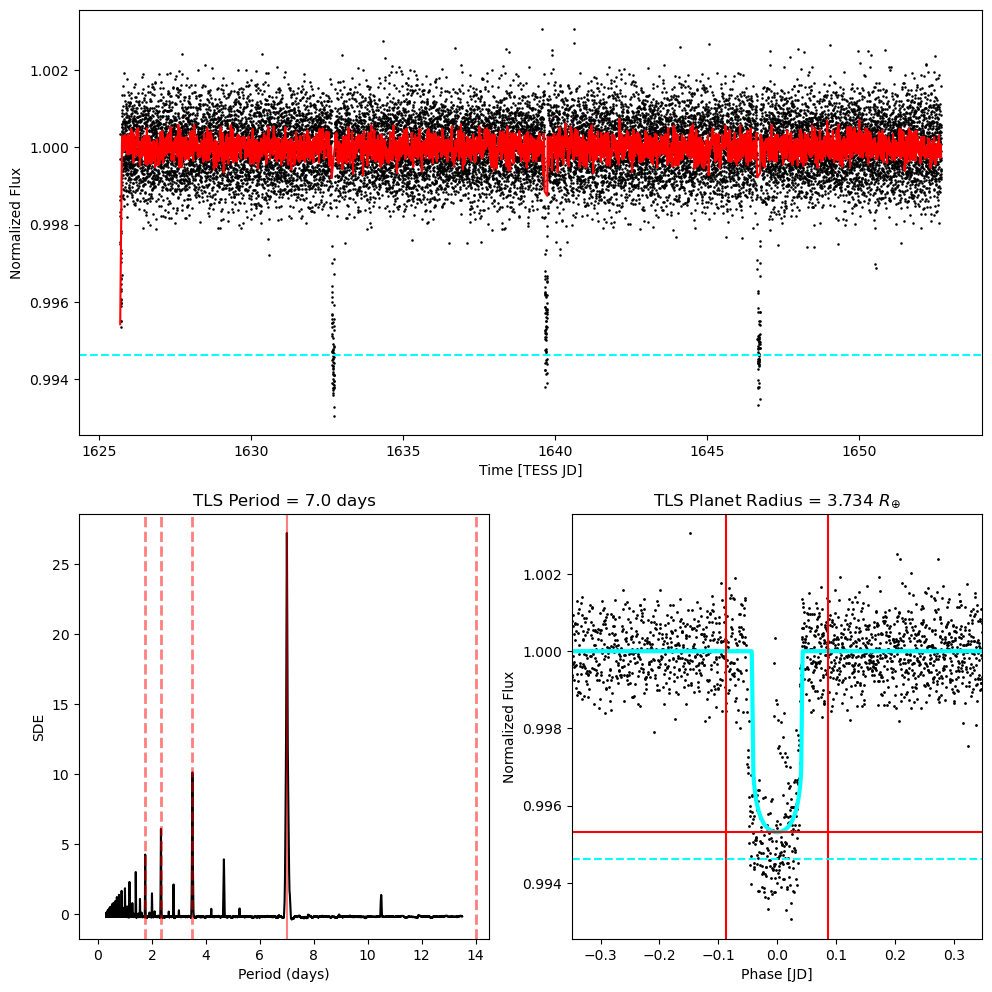

In [40]:
newlc2_SG1H_tls, trend_lc2_SG1H_tls = detrend(lc = injected_LC2, window_length = 1 / 24, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_SG1H_tls, trend_lc = trend_lc2_SG1H_tls,
                                                       filename = "LC2_TestSG1H_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:40<00:00


Searching for best T0 for period 7.00001 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2137.53it/s]


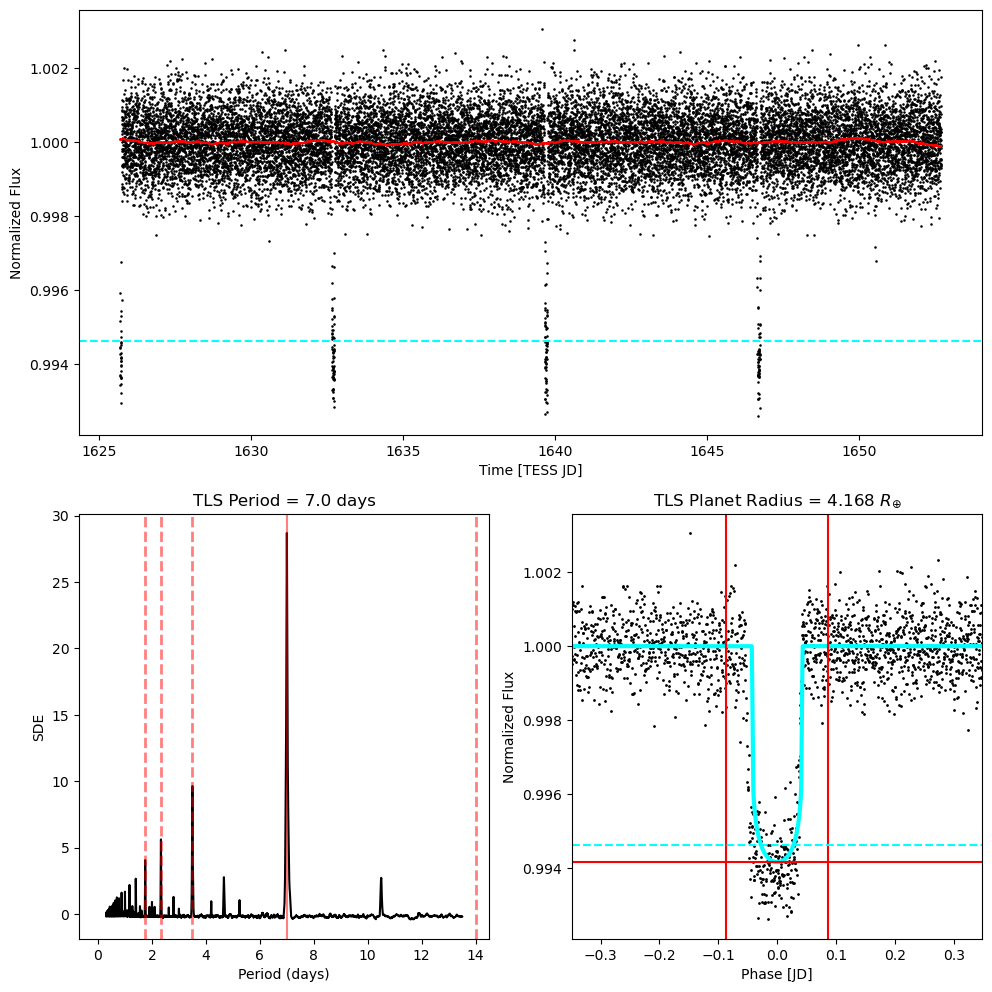

In [41]:
newlc2_W1D_tls, trend_lc2_W1D_tls = detrend(lc = injected_LC2, window_length = 1, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_W1D_tls, trend_lc = trend_lc2_W1D_tls,
                                                       filename = "LC2_TestW1D_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:26<00:00


Searching for best T0 for period 0.60635 days


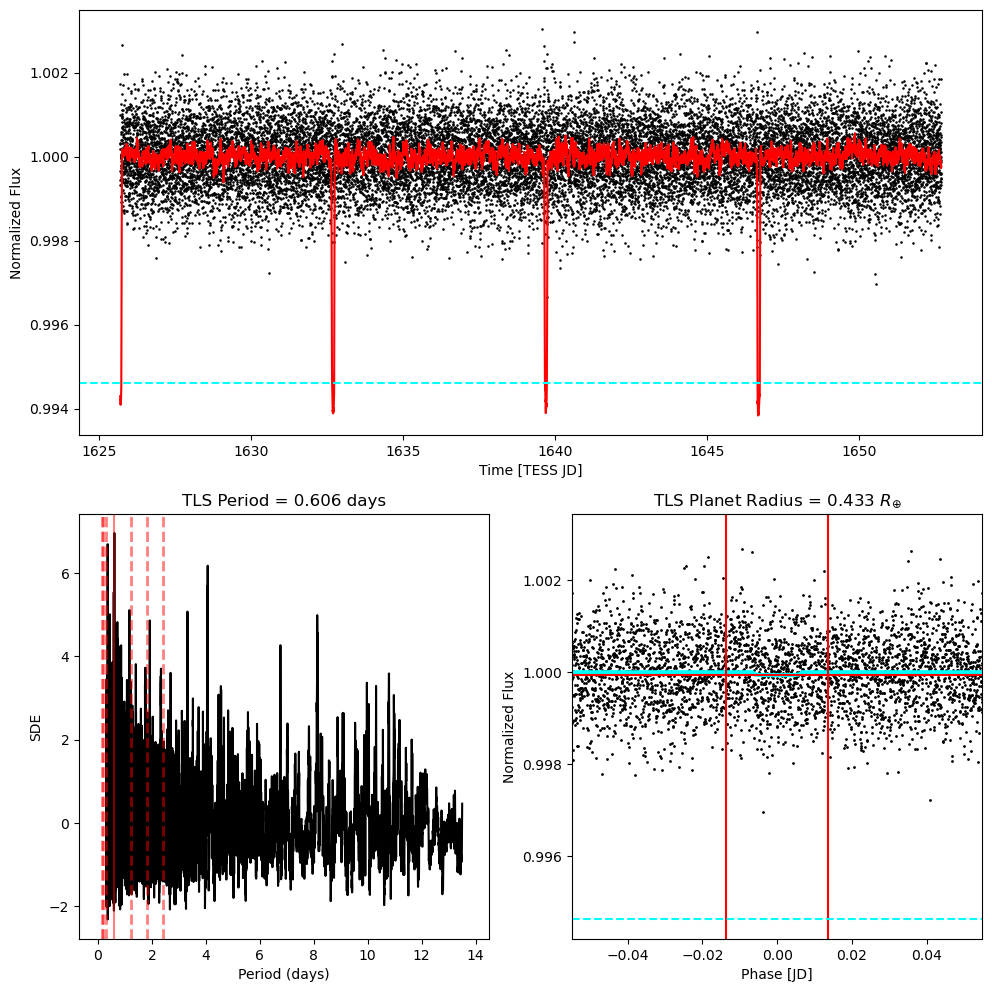

In [42]:
newlc2_W1H_tls, trend_lc2_W1H_tls = detrend(lc = injected_LC2, window_length = 1 / 24, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_W1H_tls, trend_lc = trend_lc2_W1H_tls,
                                                       filename = "LC2_TestW1H_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)

## Practice with different window sizes

### Injected LC1

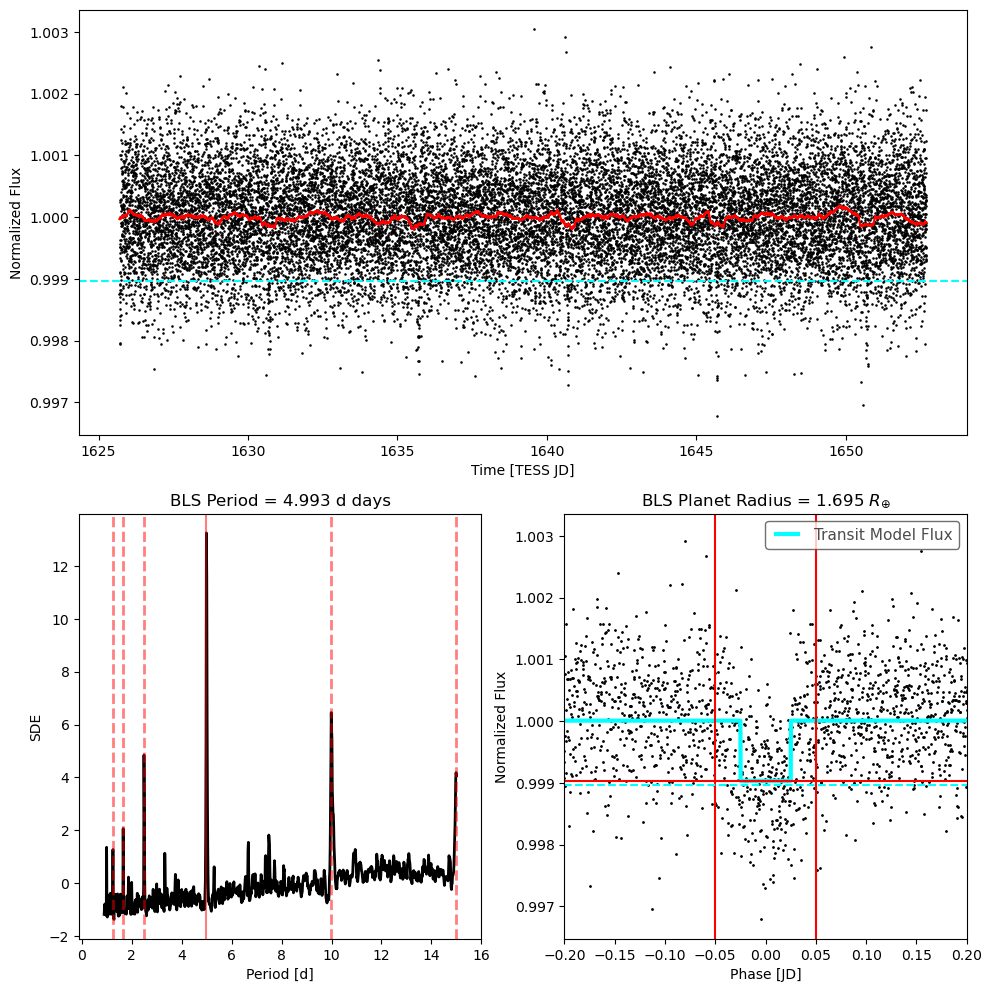

In [43]:
newlc1_W_practice, trend_lc1_W_practice = detrend(lc = injected_LC1, window_length = 12 / 24, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc1_W_practice, trend_lc = trend_lc1_W_practice,
                                                       period_minimum = 0.9, period_maximum = 15, 
                                                       n_periods = 1000, filename = "LC1_TestW12H_BLS.png", 
                                                       frequency_factor = 500,
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)

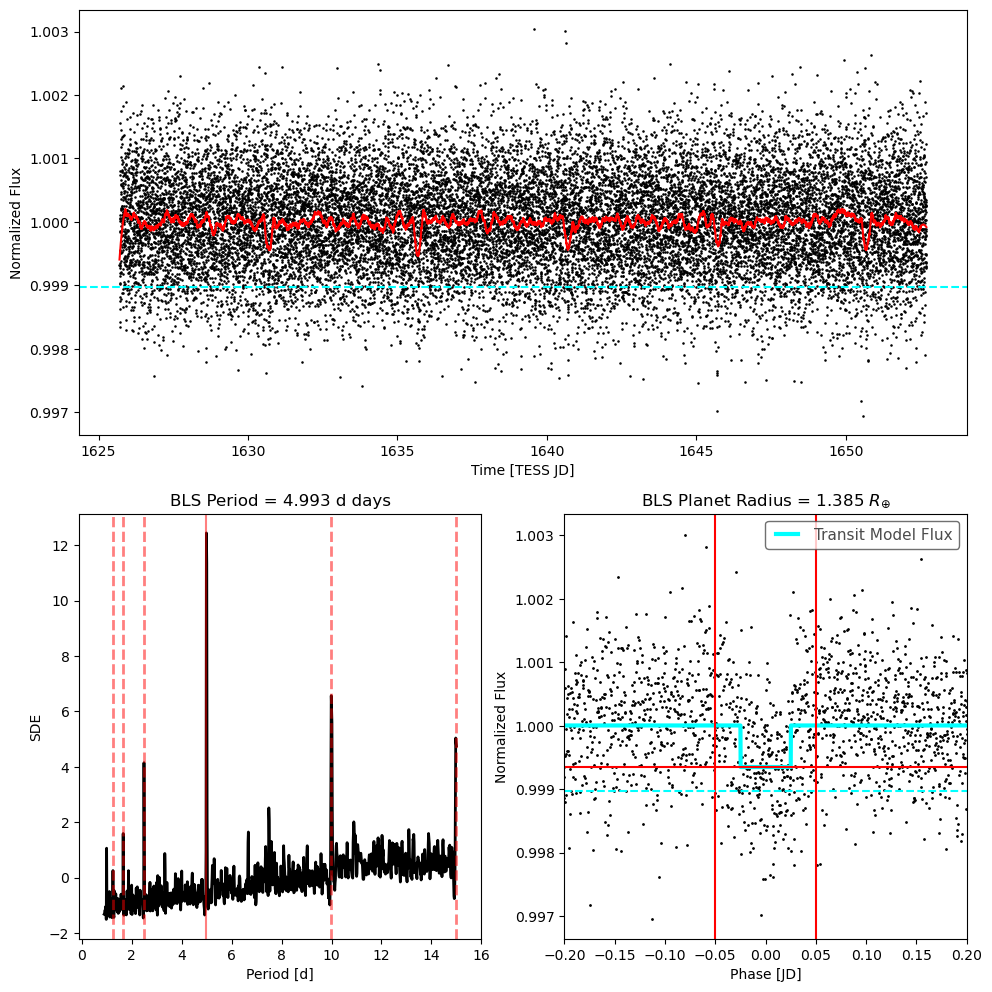

In [44]:
newlc1_SG_practice, trend_lc1_SG_practice = detrend(lc = injected_LC1, window_length = 9 / 24, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_bls(lc = newlc1_SG_practice, trend_lc = trend_lc1_SG_practice,
                                                       period_minimum = 0.9, period_maximum = 15, 
                                                       n_periods = 1000, filename = "LC1_TestSG9H_BLS.png", 
                                                       frequency_factor = 500,
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP1,
                                                       R_star=R_star)

### Injected LC2

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:40<00:00


Searching for best T0 for period 7.00001 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2147.63it/s]


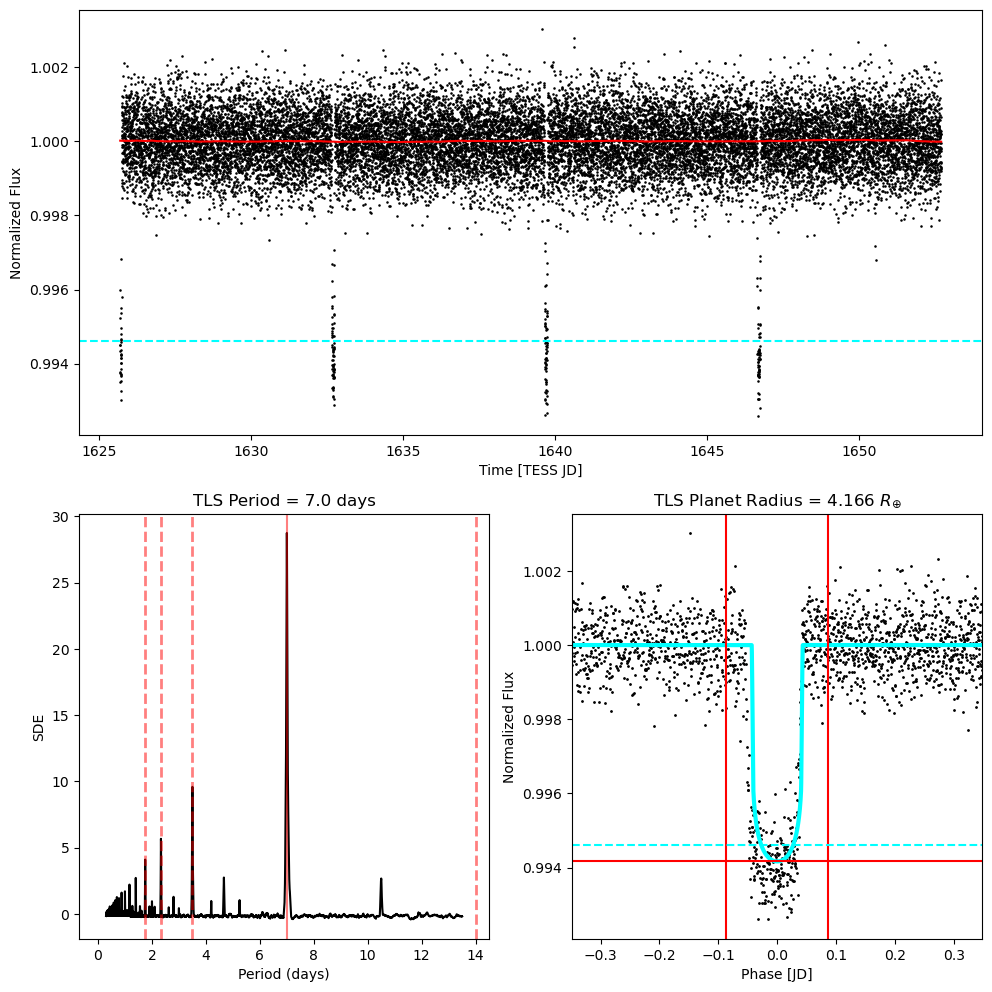

In [45]:
newlc2_W_practice, trend_lc2_W_practice = detrend(lc = injected_LC2, window_length = 4, 
                                    filter_type = "Wotan", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_W_practice, trend_lc = trend_lc2_W_practice, 
                                                   filename = "LC2_TestW4D_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 38 durations
Searching 19440 data points, 16415 periods from 0.301 to 13.5 days
Using 4 of 10 CPU threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 16415/16415 periods | 00:39<00:00


Searching for best T0 for period 7.00001 days


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:03<00:00, 2145.02it/s]


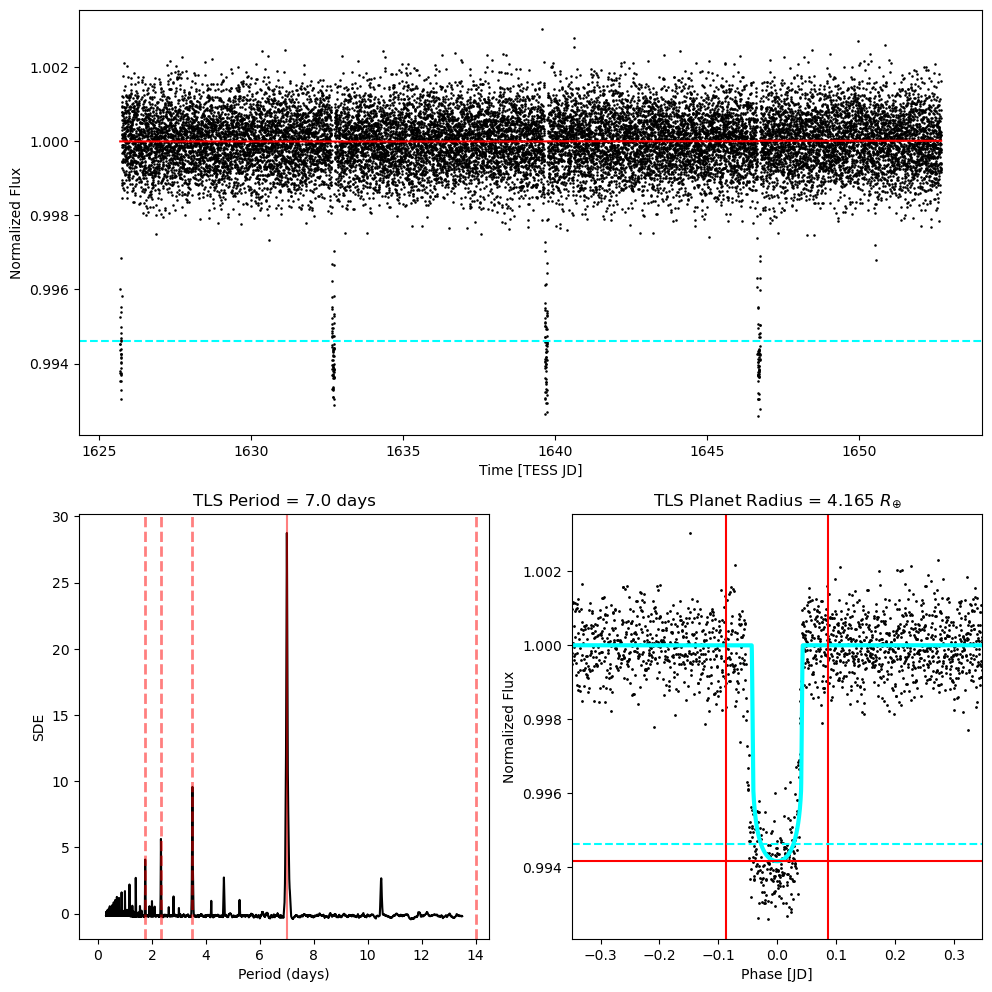

In [46]:
newlc2_SG_practice, trend_lc2_SG_practice = detrend(lc = injected_LC2, window_length = 127, 
                                      filter_type = "SG", return_trend = True)

period, epoch, duration, depth = transit_searching_tls(lc = newlc2_SG_practice, trend_lc = trend_lc2_SG_practice,
                                                   filename = "LC2_TestSG127D_TLS.png",
                                                       savepath=saveresults_path,
                                                       injected_RP_in_earth_radii=inj_RP2,
                                                       R_star=R_star,M_star=M_star,
                                                       limb_darkening_coefficients=qld2)

## Coding challenge!

Create a scatter plot that has the period detected by BLS on the x-axis and the transit depth that is detected on the y-axis

For each data point on the scatter plot, the plot should have a label and a window as a string (results[1].split('.')[0]) legend

In [50]:
print(saveresults_path)

/Users/daxfeliz/Desktop/Mentoring_Teaching/AMNH_REU/Madeline/experiment_1/


In [51]:
# Collect BLS results
# bls_results_path = "/Users/madelinejmg/Desktop/research 2024/" #old path
bls_results_path= saveresults_path

import fnmatch, os

bls_results = fnmatch.filter(os.listdir(bls_results_path), '*BLS*.csv')
print(bls_results)

print(len(bls_results))

['LC2_TestSG1D_BLS.csv', 'LC1_TestSG1H_BLS.csv', 'LC1_TestW1H_BLS.csv', 'LC1_TestW12H_BLS.csv', 'LC2_TestW1D_BLS.csv', 'LC1_TestSG9H_BLS.csv', 'LC2_TestW1H_BLS.csv', 'LC1_TestSG1D_BLS.csv', 'LC1_TestW1D_BLS.csv', 'LC2_TestSG1H_BLS.csv']
10


In [52]:
df_temp0 = pd.read_csv(bls_results_path + bls_results[0])
df_temp0

Unnamed: 0    Period         Epoch  Duration     Depth    Radius
0           0  6.997297  2.458626e+06       0.1  0.005136  3.908681

In [53]:
import pandas as pd
import numpy as np


bls_periods = []
bls_depths = []
bls_radiis = []
bls_labels = []


for x in range(len(bls_results)):
    df_temp = pd.read_csv(bls_results_path + bls_results[x])
    bls_p = df_temp['Period']
    bls_d = df_temp['Depth']
    # these are now calculated outputs!
    bls_rp = df_temp['Radius']
    # these are now calculated outputs!
    
    bls_label = bls_results[x].split('.')[0] # grabbing the filename before the period
    
    bls_periods = np.append(bls_periods, bls_p)
    bls_depths = np.append(bls_depths ,  bls_d)
    # these are now calculated outputs!
    bls_radiis = np.append(bls_radiis ,   bls_rp)
    # these are now calculated outputs!
    bls_labels = np.append(bls_label ,   bls_labels)

print(bls_labels)

['LC2_TestSG1H_BLS' 'LC1_TestW1D_BLS' 'LC1_TestSG1D_BLS' 'LC2_TestW1H_BLS'
 'LC1_TestSG9H_BLS' 'LC2_TestW1D_BLS' 'LC1_TestW12H_BLS' 'LC1_TestW1H_BLS'
 'LC1_TestSG1H_BLS' 'LC2_TestSG1D_BLS']


In [54]:
print(bls_periods); print(len(bls_periods))

[ 6.9972973  12.62882883  7.43483483  4.99309309  6.9972973   4.99309309
 10.77987988  4.99309309  4.99309309  6.9972973 ]
10


In [55]:
print(bls_depths); print(len(bls_depths))


[0.0051364  0.00020565 0.00021371 0.00096568 0.00518618 0.00064531
 0.00021402 0.00091392 0.00102683 0.0041625 ]
10


In [56]:
print(bls_radiis); print(len(bls_radiis))

[3.90868103 0.782099   0.79727625 1.69479865 3.92757679 1.38542914
 0.79786228 1.64874554 1.74763342 3.51866574]
10


In [57]:
bls_results #[3] 

['LC2_TestSG1D_BLS.csv',
 'LC1_TestSG1H_BLS.csv',
 'LC1_TestW1H_BLS.csv',
 'LC1_TestW12H_BLS.csv',
 'LC2_TestW1D_BLS.csv',
 'LC1_TestSG9H_BLS.csv',
 'LC2_TestW1H_BLS.csv',
 'LC1_TestSG1D_BLS.csv',
 'LC1_TestW1D_BLS.csv',
 'LC2_TestSG1H_BLS.csv']

In [58]:
bls_results[0].split('_')[1].split('.')

['TestSG1D']

In [59]:
bls_results[1].split('.')[0]

'LC1_TestSG1H_BLS'

## Challenge 1 (6/12)

In [60]:
import fnmatch, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

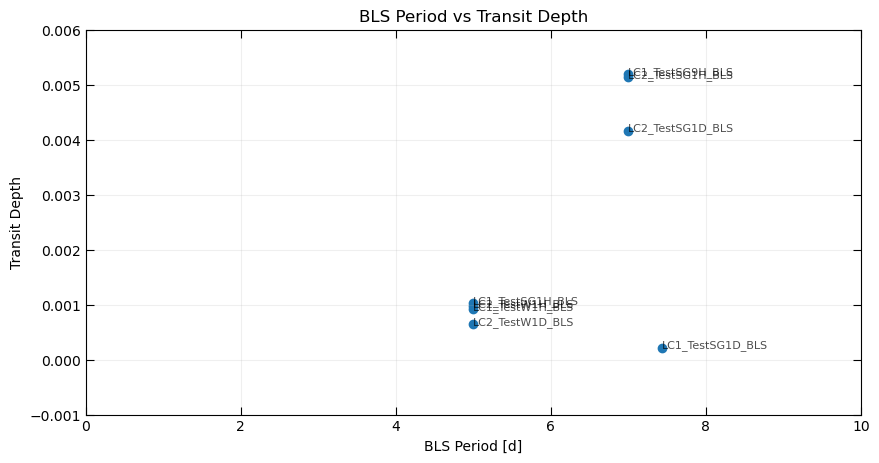

In [61]:
# Creating the plot
  
# Convert lists to numpy arrays for plotting
bls_periods = np.array(bls_periods)
bls_depths = np.array(bls_depths)
bls_labels = np.array(bls_labels)

# Create the scatter plot
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(bls_periods, bls_depths)

# Add labels for each point
for i, label in enumerate(bls_labels):
    ax.annotate(label, (bls_periods[i], bls_depths[i]), fontsize = 8, alpha = 0.7)

ax.tick_params(which = 'both', axis = 'both', direction = 'in', top = True, right = True)
ax.tick_params(which = 'major',length = 6)

from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

XminorLocator = MultipleLocator(2)  # ticks
YminorLocator = MultipleLocator(0.5)

ax.xaxis.set_minor_locator(XminorLocator)
ax.yaxis.set_minor_locator(YminorLocator)
ax.set_xlim(0, 10)
ax.set_ylim(-0.001, 0.006)

ax.set_xlabel('BLS Period [d]')
ax.set_ylabel('Transit Depth')
ax.set_title('BLS Period vs Transit Depth')

ax.grid(alpha = 0.2)

output_path = saveresults_path+"bls_scatter_plot.png"
fig.savefig(output_path, dpi = 300, bbox_inches = 'tight')

plt.show()

## Challenge 2 (6/13)

### Transit Depths and Light Curves

$\delta$ is the transit depth and ${R_{S}}$ is the radius of the star. Solving for ${R_{P}}$ is:


$$\delta = \frac{R_{P}}{R_{S}}^{2}$$


$${R_{P}} = {R_{S}}\sqrt{\delta}$$

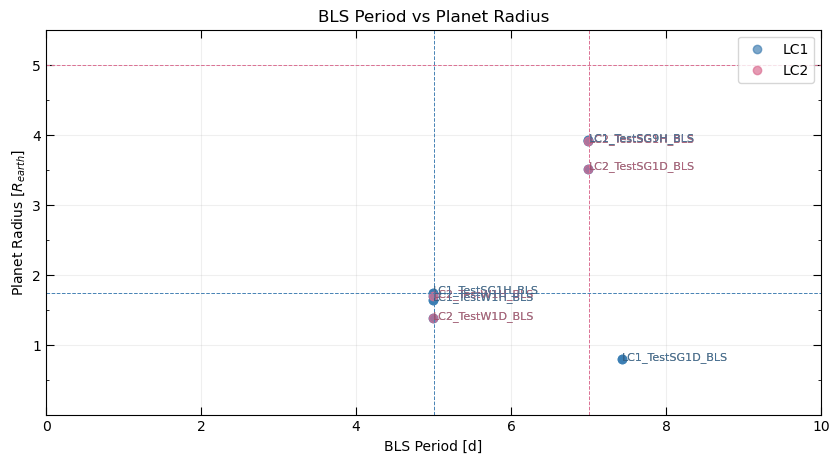

In [62]:
# bls_earth_radii = (R_star *  R_sun * np.sqrt(bls_depths)) / R_earth # in units of Earth radii #original calc
# these are now calculated outputs!
bls_earth_radii = bls_radiis

# Create the scatter plot
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(bls_periods, bls_earth_radii)

# Individual data point labels
for i, label in enumerate(bls_labels):
    ax.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7)

# Vertical lines
ax.axvline(x = 5, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax.axvline(x = 7, color ='palevioletred', linestyle = '--', linewidth = 0.7)

# Horizontal lines
ax.axhline(y = 1.75, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax.axhline(y = 5, color = 'palevioletred', linestyle = '--', linewidth = 0.7)

lc1_periods_BLS = []
lc1_radii_BLS = []
lc2_periods_BLS = []
lc2_radii_BLS = []

# Separate the data points into LC1 and LC2 categories
for i, label in enumerate(bls_labels):
    if "LC1" in label:
        lc1_periods_BLS.append(bls_periods[i])
        lc1_radii_BLS.append(bls_earth_radii[i])
    elif "LC2" in label:
        lc2_periods_BLS.append(bls_periods[i])
        lc2_radii_BLS.append(bls_earth_radii[i])

# Plot LC1 and LC2 data points with matching colors for comparison
sc1 = ax.scatter(lc1_periods_BLS, lc1_radii_BLS, color = 'steelblue', label = 'LC1', alpha = 0.7)
sc2 = ax.scatter(lc2_periods_BLS, lc2_radii_BLS, color = 'palevioletred', label = 'LC2', alpha = 0.7)

# Individual data point labels with matching colors
for i, label in enumerate(bls_labels):
    if "LC1" in label:
        ax.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'steelblue')
    elif "LC2" in label:
        ax.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'palevioletred')
    else:
        ax.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7)

ax.tick_params(which = 'both', axis = 'both', direction = 'in', top = True, right = True)
ax.tick_params(which = 'major', length = 6)

from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

XminorLocator = MultipleLocator(2) 
YminorLocator = MultipleLocator(0.5)

ax.xaxis.set_minor_locator(XminorLocator)
ax.yaxis.set_minor_locator(YminorLocator)

ax.set_xlim(0, 10)
ax.set_ylim(0.01, 5.5)

ax.set_xlabel('BLS Period [d]')
ax.set_ylabel('Planet Radius [$R_{earth}$]')
ax.set_title('BLS Period vs Planet Radius')

ax.grid(alpha = 0.2)

ax.legend(loc = 'upper right')

output_path = output_path = saveresults_path+"BLS_Earth_radii_scatter_plot.png"
fig.savefig(output_path, dpi = 300, bbox_inches = 'tight')

plt.show()

## Challenge 3 (6/20)

Do the same plot above, but for the TLS results

In [63]:
# collect our BLS results
# tls_results_path = "/Users/madelinejmg/Desktop/research 2024/" #old path
tls_results_path= saveresults_path

import fnmatch, os

tls_results = fnmatch.filter(os.listdir(tls_results_path), '*tls*.csv')
print(tls_results)

print(len(tls_results))

['LC1_TestW1D_TLS_tls.csv', 'LC2_TestW1D_TLS_tls.csv', 'LC1_TestW1H_TLS_tls.csv', 'LC2_TestW1H_TLS_tls.csv', 'LC2_TestSG1H_TLS_tls.csv', 'LC2_TestSG1D_TLS_tls.csv', 'LC2_TestSG127D_TLS_tls.csv', 'LC1_TestSG1D_TLS_tls.csv', 'LC1_TestSG1H_TLS_tls.csv', 'LC2_TestW4D_TLS_tls.csv']
10


In [64]:
df_temp0 = pd.read_csv(tls_results_path + tls_results[0])
df_temp0

Unnamed: 0    Period         Epoch  Duration     Depth    Radius
0           0  5.000915  2.458626e+06  0.077237  0.001041  1.759353

In [65]:
import pandas as pd
import numpy as np


tls_periods = []
tls_depths = []
tls_radiis = []
tls_labels = []


for x in range(len(tls_results)):
    df_temp = pd.read_csv(tls_results_path + tls_results[x])
    tls_p = df_temp['Period']
    tls_d = df_temp['Depth']
    # these are now calculated outputs!
    tls_rp = df_temp['Radius']
    # these are now calculated outputs!
    
    tls_label = tls_results[x].split('.')[0] # grabbing the filename before the period
    
    tls_periods = np.append(tls_periods, tls_p)
    tls_depths = np.append(tls_depths ,  tls_d)
    # these are now calculated outputs!
    tls_radiis = np.append(tls_radiis ,   tls_rp)
    # these are now calculated outputs!
    tls_labels = np.append(tls_label ,   tls_labels)

print(tls_labels)

['LC2_TestW4D_TLS_tls' 'LC1_TestSG1H_TLS_tls' 'LC1_TestSG1D_TLS_tls'
 'LC2_TestSG127D_TLS_tls' 'LC2_TestSG1D_TLS_tls' 'LC2_TestSG1H_TLS_tls'
 'LC2_TestW1H_TLS_tls' 'LC1_TestW1H_TLS_tls' 'LC2_TestW1D_TLS_tls'
 'LC1_TestW1D_TLS_tls']


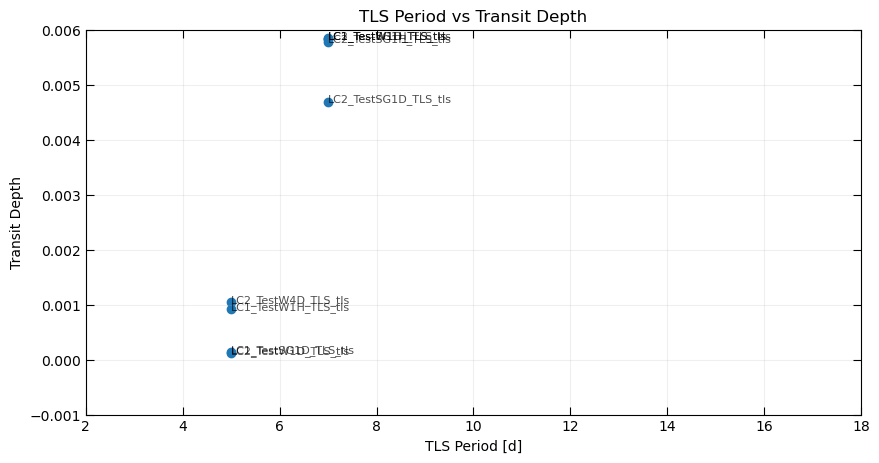

In [66]:
# Creating the plot
   
# Convert lists to numpy arrays for plotting
tls_periods = np.array(tls_periods)
tls_depths = np.array(tls_depths)
tls_labels = np.array(tls_labels)

# Create the scatter plot
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(tls_periods, tls_depths)

# Add labels for each point
for i, label in enumerate(tls_labels):
    ax.annotate(label, (tls_periods[i], tls_depths[i]), fontsize = 8, alpha = 0.7)

ax.tick_params(which = 'both', axis = 'both', direction = 'in', top = True, right = True)
ax.tick_params(which = 'major',length = 6)

from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

XminorLocator = MultipleLocator(2)  # ticks
YminorLocator = MultipleLocator(0.5)

ax.xaxis.set_minor_locator(XminorLocator)
ax.yaxis.set_minor_locator(YminorLocator)
ax.set_xlim(2, 18)
ax.set_ylim(-0.001, 0.006)

ax.set_xlabel('TLS Period [d]')
ax.set_ylabel('Transit Depth')
ax.set_title('TLS Period vs Transit Depth')

ax.grid(alpha = 0.2)

output_path = saveresults_path+"TLS_scatter_plot.png"
fig.savefig(output_path, dpi = 300, bbox_inches = 'tight')

plt.show()

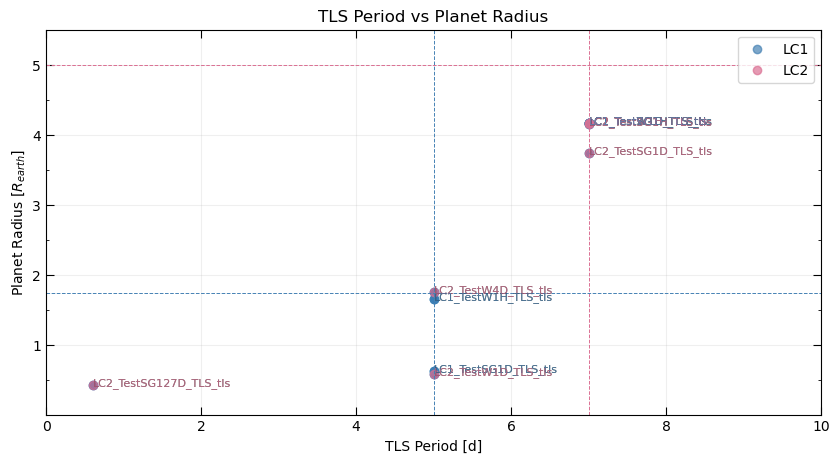

In [67]:
# tls_earth_radii = (R_star *  R_sun * np.sqrt(tls_depths)) / R_earth # in units of Earth radii #original code
# these are now calculated outputs!
tls_earth_radii = tls_radiis

# Create the scatter plot
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(tls_periods, tls_earth_radii)

# Individual data point labels
for i, label in enumerate(tls_labels):
    ax.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7)

# Vertical lines
ax.axvline(x = 5, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax.axvline(x = 7, color ='palevioletred', linestyle = '--', linewidth = 0.7)

# Horizontal lines
ax.axhline(y = 1.75, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax.axhline(y = 5, color = 'palevioletred', linestyle = '--', linewidth = 0.7)

lc1_periods_TLS = []
lc1_radii_TLS = []
lc2_periods_TLS = []
lc2_radii_TLS = []

# Separate the data points into LC1 and LC2 categories
for i, label in enumerate(tls_labels):
    if "LC1" in label:
        lc1_periods_TLS.append(tls_periods[i])
        lc1_radii_TLS.append(tls_earth_radii[i])
    elif "LC2" in label:
        lc2_periods_TLS.append(tls_periods[i])
        lc2_radii_TLS.append(tls_earth_radii[i])

# Plot LC1 and LC2 data points with matching colors for comparison
sc1 = ax.scatter(lc1_periods_TLS, lc1_radii_TLS, color = 'steelblue', label = 'LC1', alpha = 0.7)
sc2 = ax.scatter(lc2_periods_TLS, lc2_radii_TLS, color = 'palevioletred', label = 'LC2', alpha = 0.7)

# Individual data point labels with matching colors
for i, label in enumerate(tls_labels):
    if "LC1" in label:
        ax.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'steelblue')
    elif "LC2" in label:
        ax.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'palevioletred')
    else:
        ax.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7)

ax.tick_params(which = 'both', axis = 'both', direction = 'in', top = True, right = True)
ax.tick_params(which = 'major', length = 6)

from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

XminorLocator = MultipleLocator(2) 
YminorLocator = MultipleLocator(0.5)

ax.xaxis.set_minor_locator(XminorLocator)
ax.yaxis.set_minor_locator(YminorLocator)

ax.set_xlim(3, 18)
ax.set_ylim(0.01, 5.5)

ax.set_xlim(0, 10)
ax.set_ylim(0.01, 5.5)

ax.set_xlabel('TLS Period [d]')
ax.set_ylabel('Planet Radius [$R_{earth}$]')
ax.set_title('TLS Period vs Planet Radius')

ax.grid(alpha = 0.2)

ax.legend(loc = 'upper right')

output_path = saveresults_path+"TLS_Earth_radii_scatter_plot.png"
fig.savefig(output_path, dpi = 300, bbox_inches = 'tight')

plt.show()

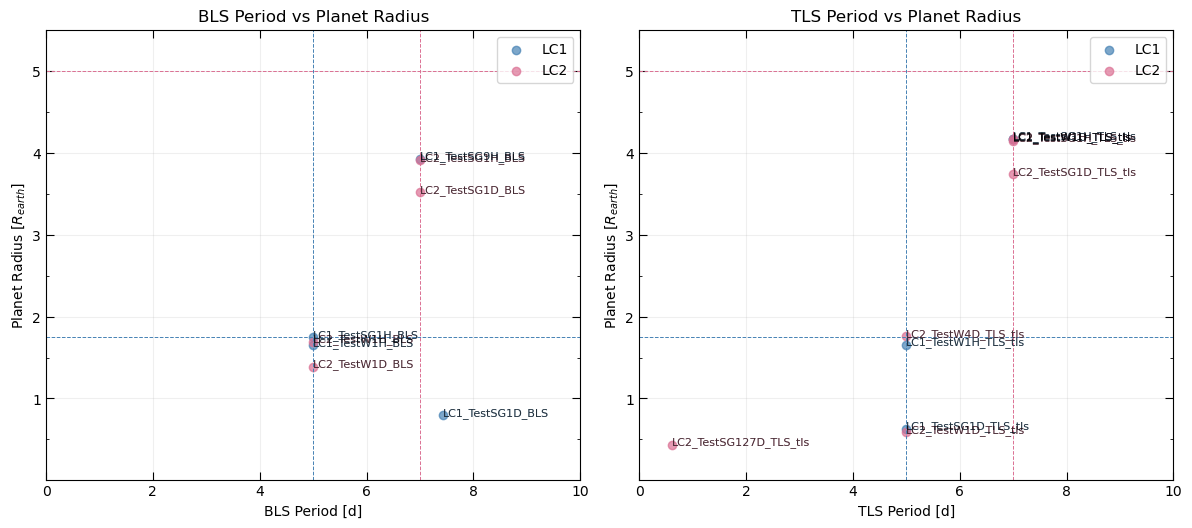

In [70]:
# place both figures on same graph side by side
fig=plt.figure(figsize=(12,10))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

sc1 = ax1.scatter(lc1_periods_BLS, lc1_radii_BLS, color = 'steelblue', label = 'LC1', alpha = 0.7)
sc2 = ax1.scatter(lc2_periods_BLS, lc2_radii_BLS, color = 'palevioletred', label = 'LC2', alpha = 0.7)

# Individual data point labels with matching colors
for i, label in enumerate(bls_labels):
    if "LC1" in label:
        ax1.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'steelblue')
    elif "LC2" in label:
        ax1.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'palevioletred')
    else:
        ax1.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7)

ax1.tick_params(which = 'both', axis = 'both', direction = 'in', top = True, right = True)
ax1.tick_params(which = 'major', length = 6)

from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

XminorLocator = MultipleLocator(2) 
YminorLocator = MultipleLocator(0.5)

ax1.xaxis.set_minor_locator(XminorLocator)
ax1.yaxis.set_minor_locator(YminorLocator)

ax1.set_xlim(0, 10)
ax1.set_ylim(0.01, 5.5)

ax1.set_xlabel('BLS Period [d]')
ax1.set_ylabel('Planet Radius [$R_{earth}$]')
ax1.set_title('BLS Period vs Planet Radius')

ax1.grid(alpha = 0.2)

ax1.legend(loc = 'upper right')

for i, label in enumerate(bls_labels):
    ax1.annotate(label, (bls_periods[i], bls_earth_radii[i]), fontsize = 8, alpha = 0.7)

# Vertical lines
ax1.axvline(x = 5, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax1.axvline(x = 7, color ='palevioletred', linestyle = '--', linewidth = 0.7)

# Horizontal lines
ax1.axhline(y = 1.75, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax1.axhline(y = 5, color = 'palevioletred', linestyle = '--', linewidth = 0.7)


sc1 = ax2.scatter(lc1_periods_TLS, lc1_radii_TLS, color = 'steelblue', label = 'LC1', alpha = 0.7)
sc2 = ax2.scatter(lc2_periods_TLS, lc2_radii_TLS, color = 'palevioletred', label = 'LC2', alpha = 0.7)

# Individual data point labels with matching colors
for i, label in enumerate(tls_labels):
    if "LC1" in label:
        ax2.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'steelblue')
    elif "LC2" in label:
        ax2.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7, color = 'palevioletred')
    else:
        ax2.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7)

ax2.tick_params(which = 'both', axis = 'both', direction = 'in', top = True, right = True)
ax2.tick_params(which = 'major', length = 6)

from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

XminorLocator = MultipleLocator(2) 
YminorLocator = MultipleLocator(0.5)

ax2.xaxis.set_minor_locator(XminorLocator)
ax2.yaxis.set_minor_locator(YminorLocator)

ax2.set_xlim(3, 18)
ax2.set_ylim(0.01, 5.5)

ax2.set_xlim(0, 10)
ax2.set_ylim(0.01, 5.5)

ax2.set_xlabel('TLS Period [d]')
ax2.set_ylabel('Planet Radius [$R_{earth}$]')
ax2.set_title('TLS Period vs Planet Radius')

ax2.grid(alpha = 0.2)

ax2.legend(loc = 'upper right')


for i, label in enumerate(tls_labels):
    ax2.annotate(label, (tls_periods[i], tls_earth_radii[i]), fontsize = 8, alpha = 0.7)

# Vertical lines
ax2.axvline(x = 5, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax2.axvline(x = 7, color ='palevioletred', linestyle = '--', linewidth = 0.7)

# Horizontal lines
ax2.axhline(y = 1.75, color = 'steelblue', linestyle = '--', linewidth = 0.7)
ax2.axhline(y = 5, color = 'palevioletred', linestyle = '--', linewidth = 0.7)

fig.tight_layout(pad=1)
output_path = saveresults_path+"BLS_vs_TLS_Earth_radii_scatter_plot.png"
fig.savefig(output_path, dpi = 300, bbox_inches = 'tight')
plt.show()

In [71]:
print('done!')

done!
